### Load Datasets
- The **energy file** records Spain’s hourly electricity prices, in Euros per mega watt hour (€/MWh); electricity generation by type of origin (coal, gas, wind power, etc.) in MWh; and energy demand (“load”) in MWh.
- The **weather file** offers the hourly records of five major Spanish cities.
- We will aim to forecast **one lag ahead**

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import pickle
import os

from pprint import pprint
from copy import deepcopy
from collections import Counter
from collections.abc import Iterable
import holidays

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

# Feature Selectionb
from boruta import BorutaPy
import tsfresh as tsf

# Sklearn
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error

# itba-ml
from itba_ml.data_processing.data_cleaner import DataCleaner
from itba_ml.modeling.models import Regressor
from itba_ml.utils.logging_helper import get_logger

# Hyper-parameter tunning
from hyperopt import fmin, hp, tpe, STATUS_OK
from hyperopt.fmin import generate_trials_to_calculate
from hyperopt.pyll.base import scope

import warnings
warnings.filterwarnings("ignore")

In [2]:
LOGGER = get_logger()

In [3]:
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None)

# Explanatory Data Analysis

In [4]:
# Energy Dataset
energy_path = os.path.join("..", "datasets", "regression", "energy_dataset.csv")
energy_df = pd.read_csv(energy_path, header=0, parse_dates=["time"])

# Weather Features
weather_path = os.path.join("..", "datasets", "regression", "weather_features.csv")
weather_df = pd.read_csv(weather_path, header=0, parse_dates=["dt_iso"])

### Energy Data - Data Analysis & Data Cleaning

In [5]:
# Prepare idx
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True, infer_datetime_format=True).dt.tz_localize(None)
energy_df.set_index('time', inplace=True)

#### Basic Characteristics

In [6]:
energy_df.head()

generation biomass  generation fossil brown coal/lignite  \
time                                                                            
2014-12-31 23:00:00               447.0                                 329.0   
2015-01-01 00:00:00               449.0                                 328.0   
2015-01-01 01:00:00               448.0                                 323.0   
2015-01-01 02:00:00               438.0                                 254.0   
2015-01-01 03:00:00               428.0                                 187.0   

                     generation fossil coal-derived gas  \
time                                                      
2014-12-31 23:00:00                                 0.0   
2015-01-01 00:00:00                                 0.0   
2015-01-01 01:00:00                                 0.0   
2015-01-01 02:00:00                                 0.0   
2015-01-01 03:00:00                                 0.0   

                     generation fossil gas  generation fossil hard coal  \
time                                                                      
2014-12-31 23:00:00                 4844.0                       4821.0   
2015-01-01 00:00:00                 5196.0                       4755.0   
2015-01-01 01:00:00                 4857.0                       4581.0   
2015-01-01 02:00:00                 4314.0                       4131.0   
2015-01-01 03:00:00                 4130.0                       3840.0   

                     generation fossil oil  generation fossil oil shale  \
time                                                                      
2014-12-31 23:00:00                  162.0                          0.0   
2015-01-01 00:00:00                  158.0                          0.0   
2015-01-01 01:00:00                  157.0                          0.0   
2015-01-01 02:00:00                  160.0                          0.0   
2015-01-01 03:00:00                  156.0                          0.0   

                     generation fossil peat  generation geothermal  \
time                                                                 
2014-12-31 23:00:00                     0.0                    0.0   
2015-01-01 00:00:00                     0.0                    0.0   
2015-01-01 01:00:00                     0.0                    0.0   
2015-01-01 02:00:00                     0.0                    0.0   
2015-01-01 03:00:00                     0.0                    0.0   

                     generation hydro pumped storage aggregated  \
time                                                              
2014-12-31 23:00:00                                         NaN   
2015-01-01 00:00:00                                         NaN   
2015-01-01 01:00:00                                         NaN   
2015-01-01 02:00:00                                         NaN   
2015-01-01 03:00:00                                         NaN   

                     generation hydro pumped storage consumption  \
time                                                               
2014-12-31 23:00:00                                        863.0   
2015-01-01 00:00:00                                        920.0   
2015-01-01 01:00:00                                       1164.0   
2015-01-01 02:00:00                                       1503.0   
2015-01-01 03:00:00                                       1826.0   

                     generation hydro run-of-river and poundage  \
time                                                              
2014-12-31 23:00:00                                      1051.0   
2015-01-01 00:00:00                                      1009.0   
2015-01-01 01:00:00                                       973.0   
2015-01-01 02:00:00                                       949.0   
2015-01-01 03:00:00                                       953.0   

                     generation hydro water reservoir  generation marine  \
tim

In [7]:
energy_df.describe()

generation biomass  generation fossil brown coal/lignite  \
count        35045.000000                          35046.000000   
mean           383.513540                            448.059208   
std             85.353943                            354.568590   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0           35046.000000   
mean                                  0.0            5622.737488   
std                                   0.0            2201.830478   
min                                   0.0               0.000000   
25%                                   0.0            4126.000000   
50%                                   0.0            4969.000000   
75%                                   0.0            6429.000000   
max                                   0.0           20034.000000   

       generation fossil hard coal  generation fossil oil  \
count                 35046.000000           35045.000000   
mean                   4256.065742             298.319789   
std                    1961.601013              52.520673   
min                       0.000000               0.000000   
25%                    2527.000000             263.000000   
50%                    4474.000000             300.000000   
75%                    5838.750000             330.000000   
max                    8359.000000             449.000000   

       generation fossil oil shale  generation fossil peat  \
count                      35046.0                 35046.0   
mean                           0.0                     0.0   
std                            0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   

       generation geothermal  generation hydro pumped storage aggregated  \
count                35046.0                                         0.0   
mean                     0.0                                         NaN   
std                      0.0                                         NaN   
min                      0.0                                         NaN   
25%                      0.0                                         NaN   
50%                      0.0                                         NaN   
75%                      0.0                                         NaN   
max                      0.0                                         NaN   

       generation hydro pumped storage consumption  \
count                                 35045.000000   
mean                                    475.577343   
std                                     792.406614   
min                                       0.000000   
25%                                       0.000000   
50%                                      68.000000   
75%                                     616.000000   
max                                    4523.000000   

       generation hydro run-of-river and poundage  \
count                                35045.000000   
mean                                   972.116108   
std                                    400.777536   
min                                      0.000000   
25%                                    637.000000   
50%                                    906.000000   
75%                                   1250.000000   
max                                   2000.000000   

       generation hydro water r

In [8]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00 to 2018-12-31 22:00:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35045 non-null  float64
 1   generation fossil brown coal/lignite         35046 non-null  float64
 2   generation fossil coal-derived gas           35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation fossil oil shale                  35046 non-null  float64
 7   generation fossil peat                       35046 non-null  float64
 8   generation geothermal                        35046 non-null  float64
 9   generation hydro pumped storage aggre

#### Missing Values
- We observe two empty feature columns. On the right-hand side, we notice a few gaps in individual rows of the other columns.

<Axes: >

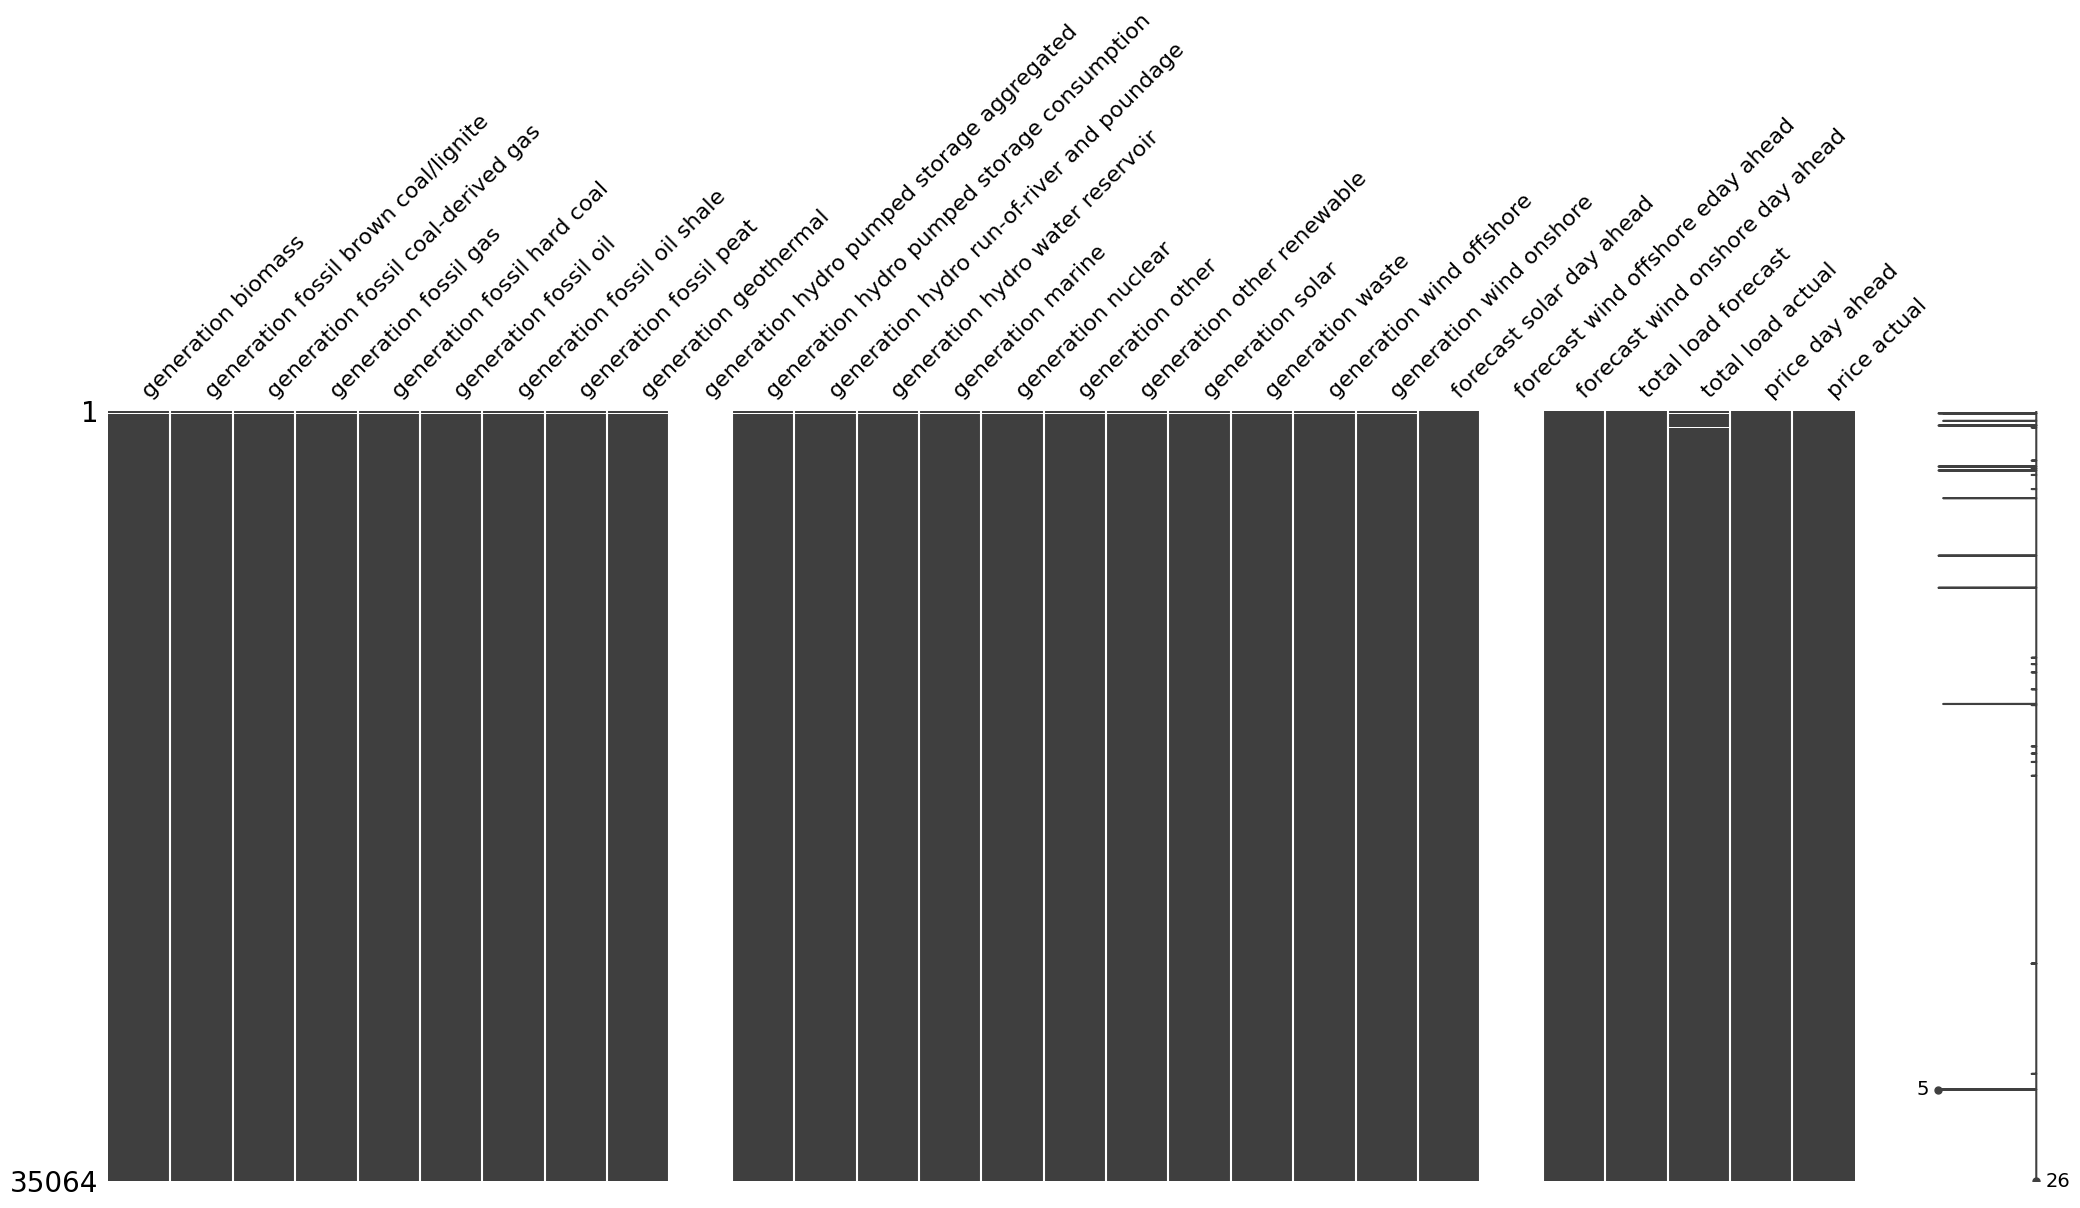

In [9]:
msno.matrix(energy_df)

In [10]:
# Instanciate DataCleaner
DC = DataCleaner(df=energy_df)

In [11]:
# Drop:
#   - Forecasting columns
#   - Columns with all null values
#   - Columns with all values equal to 0
DC.drop_unuseful_columns(
    drop_columns=energy_df.filter(regex="forecast").columns
)

In [12]:
# Rename columns
#   - The original column names contain some spaces and special characters.
rename_dict = {
    'generation biomass': 'gen_bio', 
    'generation fossil brown coal/lignite': 'gen_lig', 
    'generation fossil coal-derived gas': 'gen_coal_gas', 
    'generation fossil gas': 'gen_gas', 
    'generation fossil hard coal': 'gen_coal', 
    'generation fossil oil': 'gen_oil', 
    'generation fossil oil shale': 'gen_oil_shale', 
    'generation fossil peat': 'gen_peat', 
    'generation geothermal': 'gen_geo', 
    'generation hydro pumped storage consumption': 'gen_hyd_pump', 
    'generation hydro run-of-river and poundage': 'gen_hyd_river', 
    'generation hydro water reservoir': 'gen_hyd_res', 
    'generation marine': 'gen_mar', 
    'generation nuclear': 'gen_nuc', 
    'generation other': 'gen_other', 
    'generation other renewable': 'gen_oth_renew', 
    'generation solar': 'gen_sol', 
    'generation waste': 'gen_waste', 
    'generation wind offshore': 'gen_wind_off', 
    'generation wind onshore': 'gen_wind_on', 
    'total load actual': 'load_actual', 
    'price day ahead': 'price_dayahead', 
    'price actual': 'price'
}

DC.rename_columns(rename_dict=rename_dict)

In [13]:
# Remove duplicates
DC.remove_duplicates()

itba_ml.data_processing.data_cleaner: 2024-05-27 12:07:58,827 | INFO | data_cleaner.py:45 | Duplicated idxs: 0


In [14]:
# Drop outliers, basedd on Z score
DC.drop_outliers()

itba_ml.data_processing.data_cleaner: 2024-05-27 12:07:58,843 | INFO | data_cleaner.py:59 | Numerical Max obs:
   gen_bio  gen_lig  gen_coal_gas  gen_gas  gen_coal  gen_oil  gen_oil_shale  \
0    592.0    999.0           0.0  19821.0    8359.0    449.0            0.0   

   gen_peat  gen_geo  gen_hyd_pump  gen_hyd_river  gen_hyd_res  gen_mar  \
0       0.0      0.0        4421.0         2000.0       9728.0      0.0   

   gen_nuc  gen_other  gen_oth_renew  gen_sol  gen_waste  gen_wind_off  \
0   7117.0      106.0          119.0   5792.0      357.0           0.0   

   gen_wind_on  load_actual  price_dayahead  price  
0      17436.0      40693.0            86.4  93.23  



In [15]:
# Interpolate missing values & outliers
DC.fill_null_values(method='interpolate')

itba_ml.data_processing.data_cleaner: 2024-05-27 12:07:58,871 | INFO | data_cleaner.py:97 | Null values: 0


In [16]:
energy_df = DC.df.copy()

In [17]:
energy_df.describe()

gen_bio       gen_lig  gen_coal_gas       gen_gas      gen_coal  \
count  35064.000000  35064.000000       35064.0  35064.000000  35064.000000   
mean     383.802247    448.880062           0.0   5624.647830   4267.789727   
std       85.261339    353.926896           0.0   2171.459252   1951.779488   
min        0.000000      0.000000           0.0      0.000000      0.000000   
25%      333.000000      0.000000           0.0   4136.000000   2548.000000   
50%      367.000000    510.000000           0.0   4976.437500   4484.000000   
75%      434.000000    757.000000           0.0   6425.000000   5843.000000   
max      592.000000    999.000000           0.0  19821.000000   8359.000000   

            gen_oil  gen_oil_shale  gen_peat  gen_geo  gen_hyd_pump  \
count  35064.000000        35064.0   35064.0  35064.0  35064.000000   
mean     298.872804            0.0       0.0      0.0    449.051092   
std       51.948606            0.0       0.0      0.0    747.646107   
min        0.000000            0.0       0.0      0.0      0.000000   
25%      264.000000            0.0       0.0      0.0      0.000000   
50%      300.000000            0.0       0.0      0.0     68.950000   
75%      330.000000            0.0       0.0      0.0    583.000000   
max      449.000000            0.0       0.0      0.0   4421.000000   

       gen_hyd_river   gen_hyd_res  gen_mar       gen_nuc     gen_other  \
count   35064.000000  35064.000000  35064.0  35064.000000  35064.000000   
mean      972.304757   2620.263832      0.0   6267.026366     60.263319   
std       401.727164   1849.099479      0.0    838.023959     20.152577   
min         0.000000      0.000000      0.0      0.000000      0.000000   
25%       636.000000   1089.000000      0.0   5778.000000     53.000000   
50%       905.000000   2171.900000      0.0   6586.000000     57.000000   
75%      1250.000000   3767.000000      0.0   7024.000000     80.000000   
max      2000.000000   9728.000000      0.0   7117.000000    106.000000   

       gen_oth_renew       gen_sol     gen_waste  gen_wind_off   gen_wind_on  \
count   35064.000000  35064.000000  35064.000000       35064.0  35064.000000   
mean       85.709232   1420.510766    269.664784           0.0   5456.345753   
std        13.991858   1670.352161     49.960488           0.0   3202.331139   
min         0.000000      0.000000      0.000000           0.0      0.000000   
25%        74.000000     74.000000    241.000000           0.0   2938.750000   
50%        88.000000    614.000000    280.000000           0.0   4847.500000   
75%        97.000000   2536.000000    310.000000           0.0   7382.000000   
max       119.000000   5792.000000    357.000000           0.0  17436.000000   

        load_actual  price_dayahead         price  
count  35064.000000    35064.000000  35064.000000  
mean   28745.734158       50.152332     58.056098  
std     4494.122532       13.788969     13.525903  
min    18041.000000       13.340000     22.390000  
25%    24945.000000       41.550000     49.370000  
50%    28945.500000       50.540000     58.050000  
75%    32155.000000       60.530000     68.030000  
max    40693.000000       86.400000     93.230000

### Target Anlysis
- A lineplot of the hourly prices shows that the curve that does not appear to follow a stable long-term trend or a single seasonality pattern, but fluctuates around a mean price of €60. 
- Since we deal with hourly prices, there might also be seasonalities related to **hours**, **weekdays** & **months**

<Axes: xlabel='time', ylabel='price'>

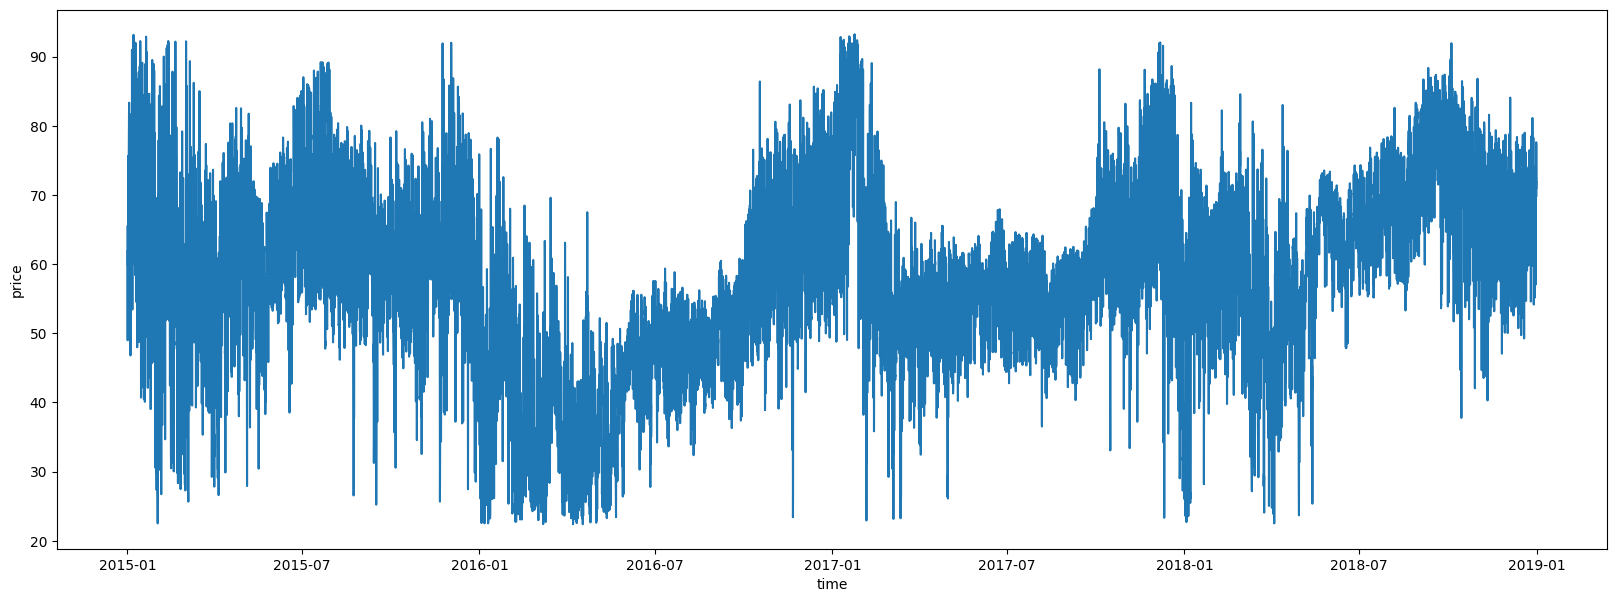

In [18]:
plt.figure(100, figsize=(20, 7))
sns.lineplot(
    x="time", 
    y="price", 
    data=energy_df, 
    palette="coolwarm"
)

#### Auto-Correlations & Partial Auto-Correlations
- Both plots show statistically significant AC values and PAC values
- This indicates that the data is autocorrelated, which could imply that there are some seasonality effects.

<Figure size 2000x700 with 0 Axes>

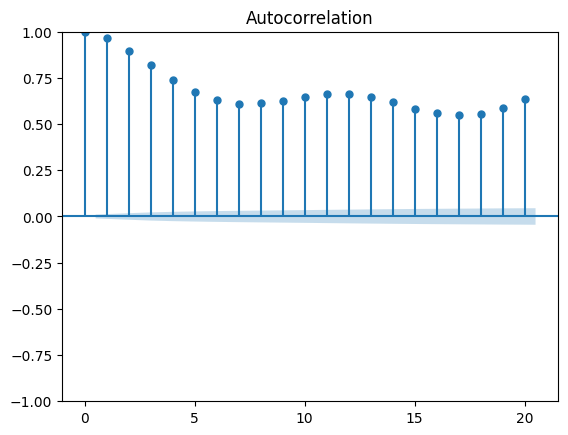

In [19]:
plt.figure(100, figsize=(20, 7))
plot_acf(energy_df['price'], lags=20, alpha=0.05)
plt.show()

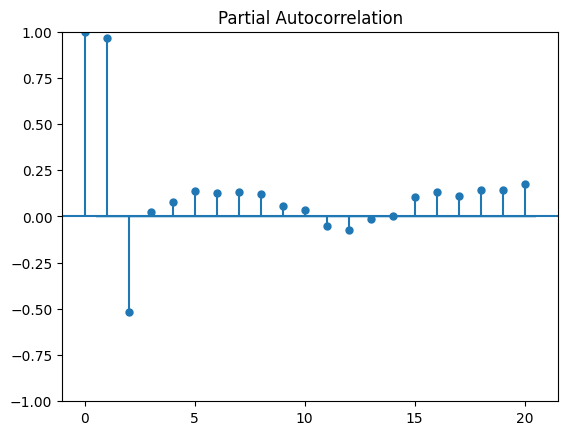

In [20]:
plot_pacf(energy_df['price'], lags=20, alpha=0.05)
plt.show()

#### Seasonal decomposition
- Decomposing the time series with both **weekly** and **monthly** frequencies portray a decisive seasonality component for the time series.

In [21]:
# Define data to plot
last_year = energy_df.loc[energy_df.index > '2018', 'price']

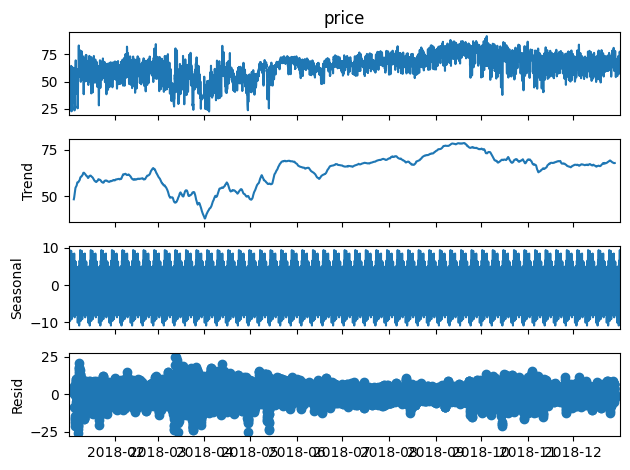

In [22]:
# Plot Weekly frequency
decomp = seasonal_decompose(last_year, period=24*7)

decomp.plot()
plt.show()

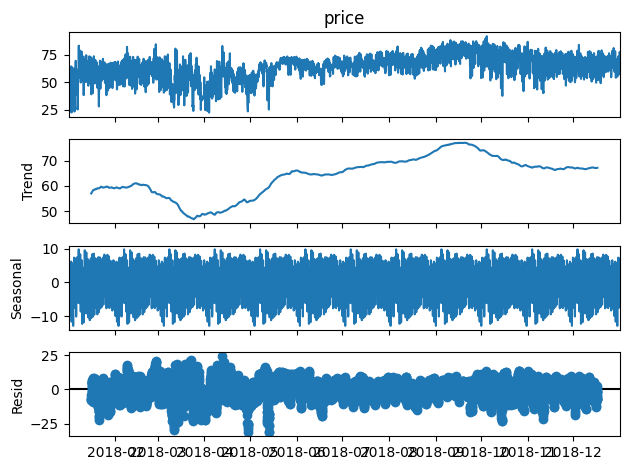

In [23]:
# Plot Monthly frequency
decomp = seasonal_decompose(last_year, period=24*30)

decomp.plot()
plt.show()

### Weather Data - Data Analysis & Data Cleaning

In [24]:
# Prepare idx
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], utc=True, infer_datetime_format=True).dt.tz_localize(None)
weather_df.set_index('dt_iso', inplace=True)

#### Basic Characteristics

In [25]:
weather_df.head()

city_name     temp  temp_min  temp_max  pressure  \
dt_iso                                                                 
2014-12-31 23:00:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 00:00:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 01:00:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 02:00:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 03:00:00  Valencia  269.686   269.686   269.686      1002   

                     humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
dt_iso                                                                  
2014-12-31 23:00:00        77           1        62      0.0      0.0   
2015-01-01 00:00:00        77           1        62      0.0      0.0   
2015-01-01 01:00:00        78           0        23      0.0      0.0   
2015-01-01 02:00:00        78           0        23      0.0      0.0   
2015-01-01 03:00:00        78           0        23      0.0      0.0   

                     snow_3h  clouds_all  weather_id weather_main  \
dt_iso                                                              
2014-12-31 23:00:00      0.0           0         800        clear   
2015-01-01 00:00:00      0.0           0         800        clear   
2015-01-01 01:00:00      0.0           0         800        clear   
2015-01-01 02:00:00      0.0           0         800        clear   
2015-01-01 03:00:00      0.0           0         800        clear   

                    weather_description weather_icon  
dt_iso                                                
2014-12-31 23:00:00        sky is clear          01n  
2015-01-01 00:00:00        sky is clear          01n  
2015-01-01 01:00:00        sky is clear          01n  
2015-01-01 02:00:00        sky is clear          01n  
2015-01-01 03:00:00        sky is clear          01n

In [26]:
weather_df.city_name.unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

In [27]:
weather_df.describe()

temp       temp_min       temp_max      pressure  \
count  178396.000000  178396.000000  178396.000000  1.783960e+05   
mean      289.618605     288.330442     291.091267  1.069261e+03   
std         8.026199       7.955491       8.612454  5.969632e+03   
min       262.240000     262.240000     262.240000  0.000000e+00   
25%       283.670000     282.483602     284.650000  1.013000e+03   
50%       289.150000     288.150000     290.150000  1.018000e+03   
75%       295.150000     293.730125     297.150000  1.022000e+03   
max       315.600000     315.150000     321.150000  1.008371e+06   

            humidity    wind_speed       wind_deg        rain_1h  \
count  178396.000000  178396.00000  178396.000000  178396.000000   
mean       68.423457       2.47056     166.591190       0.075492   
std        21.902888       2.09591     116.611927       0.398847   
min         0.000000       0.00000       0.000000       0.000000   
25%        53.000000       1.00000      55.000000       0.000000   
50%        72.000000       2.00000     177.000000       0.000000   
75%        87.000000       4.00000     270.000000       0.000000   
max       100.000000     133.00000     360.000000      12.000000   

             rain_3h        snow_3h     clouds_all     weather_id  
count  178396.000000  178396.000000  178396.000000  178396.000000  
mean        0.000380       0.004763      25.073292     759.831902  
std         0.007288       0.222604      30.774129     108.733223  
min         0.000000       0.000000       0.000000     200.000000  
25%         0.000000       0.000000       0.000000     800.000000  
50%         0.000000       0.000000      20.000000     800.000000  
75%         0.000000       0.000000      40.000000     801.000000  
max         2.315000      21.500000     100.000000     804.000000

In [28]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178396 entries, 2014-12-31 23:00:00 to 2018-12-31 22:00:00
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   city_name            178396 non-null  object 
 1   temp                 178396 non-null  float64
 2   temp_min             178396 non-null  float64
 3   temp_max             178396 non-null  float64
 4   pressure             178396 non-null  int64  
 5   humidity             178396 non-null  int64  
 6   wind_speed           178396 non-null  int64  
 7   wind_deg             178396 non-null  int64  
 8   rain_1h              178396 non-null  float64
 9   rain_3h              178396 non-null  float64
 10  snow_3h              178396 non-null  float64
 11  clouds_all           178396 non-null  int64  
 12  weather_id           178396 non-null  int64  
 13  weather_main         178396 non-null  object 
 14  weather_description  178396 non-nu

#### Missing Values
- No missing values were found

<Axes: >

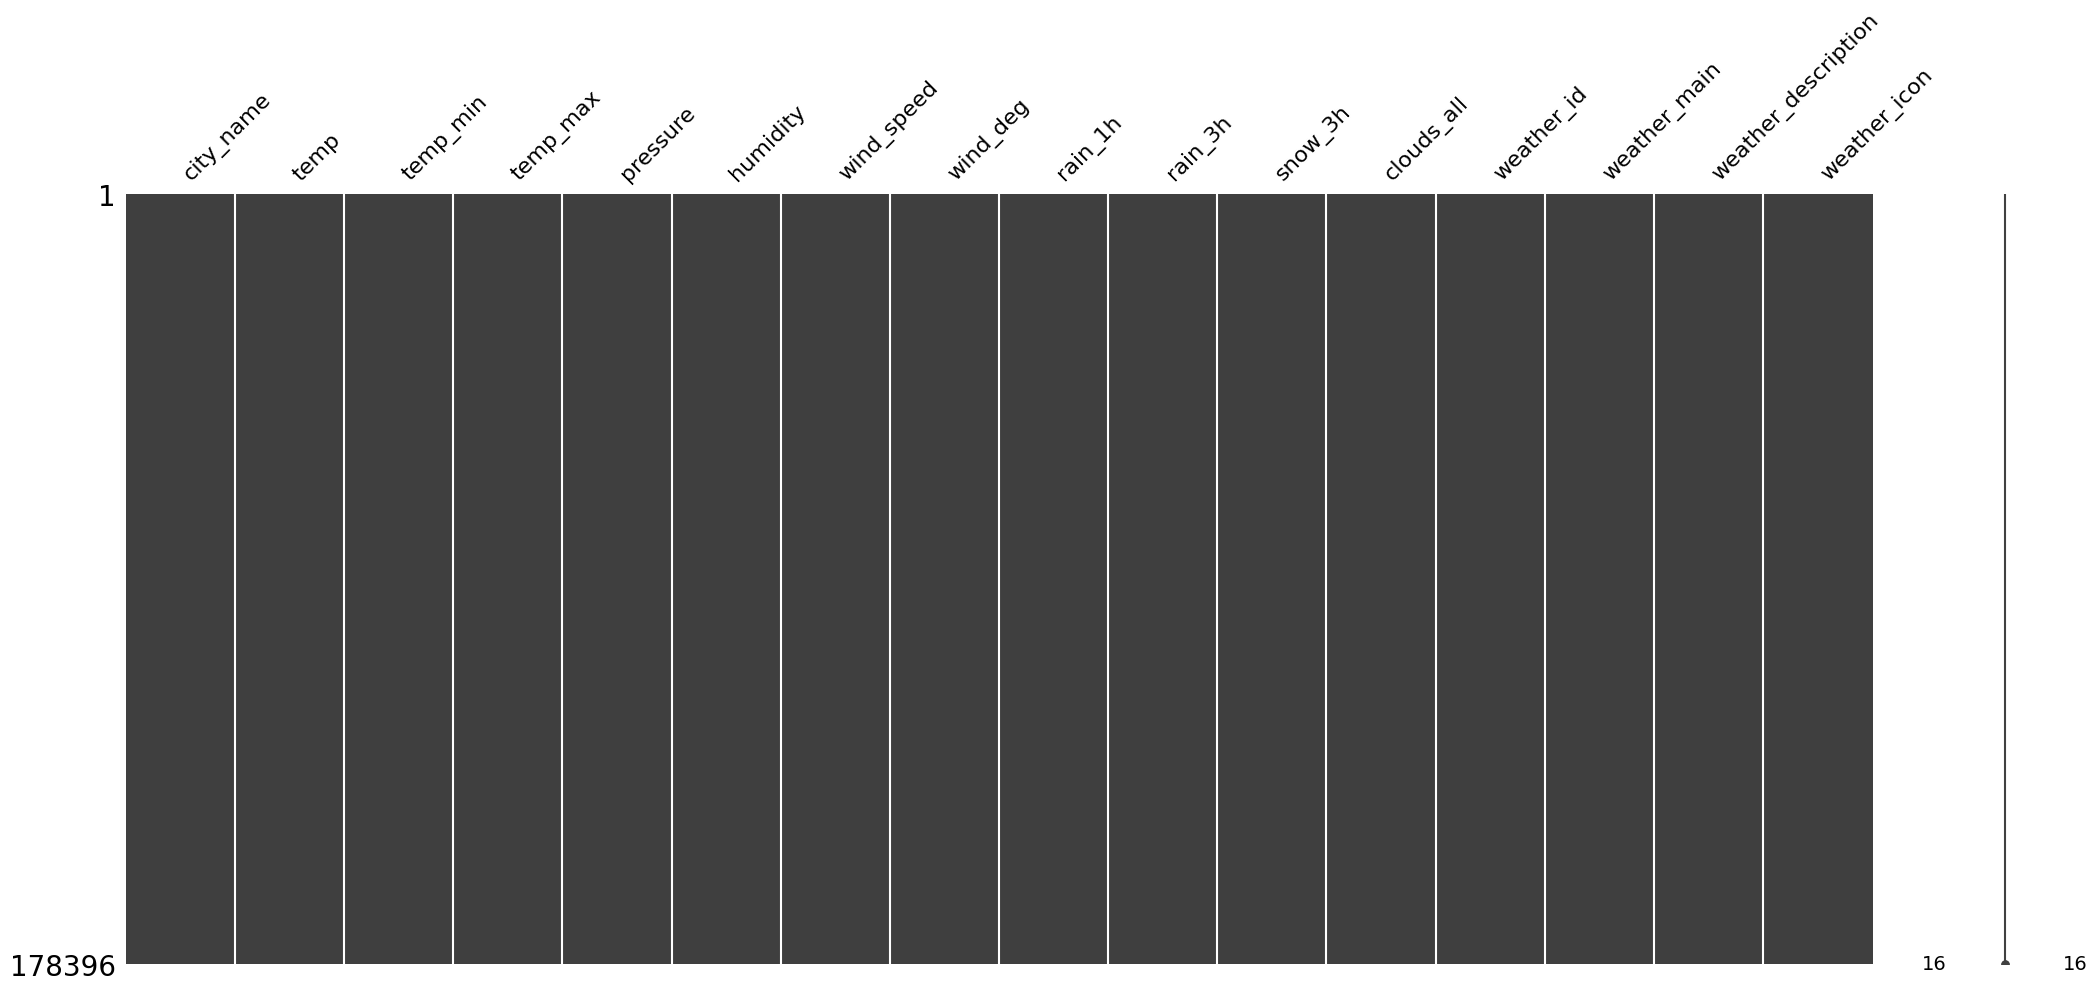

In [29]:
msno.matrix(weather_df)

In [30]:
DC = DataCleaner(df=weather_df)

In [31]:
# Drop:
#   - Drop unnecessary weather columns
#   - Columns with all null values
#   - Columns with all values equal to 0
drop_columns = ["rain_3h", "weather_id", "weather_main", "weather_description", "weather_icon"]
DC.drop_unuseful_columns(drop_columns=drop_columns)

#### Basic Transformations

In [32]:
weather_df = DC.df.copy()

In [33]:
# temperature: kelvin to celsius
temp_cols = [col for col in weather_df.columns if "temp" in col]
weather_df[temp_cols] = weather_df[temp_cols].filter(like="temp").applymap(lambda t: t - 273.15)

In [34]:
# convert int and float64 columns to float32
intcols = list(weather_df.dtypes[weather_df.dtypes == np.int64].index)
weather_df[intcols] = weather_df[intcols].applymap(np.float32)

f64cols = list(weather_df.dtypes[weather_df.dtypes == np.float64].index)
weather_df[f64cols] = weather_df[f64cols].applymap(np.float32)

f32cols = list(weather_df.dtypes[weather_df.dtypes == np.float32].index)

In [35]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178396 entries, 2014-12-31 23:00:00 to 2018-12-31 22:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   city_name   178396 non-null  object 
 1   temp        178396 non-null  float32
 2   temp_min    178396 non-null  float32
 3   temp_max    178396 non-null  float32
 4   pressure    178396 non-null  float32
 5   humidity    178396 non-null  float32
 6   wind_speed  178396 non-null  float32
 7   wind_deg    178396 non-null  float32
 8   rain_1h     178396 non-null  float32
 9   snow_3h     178396 non-null  float32
 10  clouds_all  178396 non-null  float32
dtypes: float32(10), object(1)
memory usage: 9.5+ MB


#### Duplicates

In [36]:
# Remove duplicated rows
weather_df = (
    weather_df
    .reset_index()
    .drop_duplicates(subset=["dt_iso", "city_name"], keep="first")
    .set_index('dt_iso')
)

In [37]:
# Remove duplicated columns
weather_df = weather_df.loc[:, ~weather_df.columns.duplicated(keep='first')]

#### Re-group DataFrames

In [38]:
gb_df = weather_df.groupby("city_name")

In [39]:
def format_df(df: pd.DataFrame, city: str):
    df.drop(columns=['city_name'], inplace=True)
    return df.add_suffix(f"_{city.replace(' ', '')}")

concat_weather_df: pd.DataFrame = pd.concat(
    [format_df(gb_df.get_group(city), city) for city in gb_df.groups.keys()],
    axis=1
).interpolate()

In [40]:
concat_weather_df.head()

temp_Barcelona  temp_min_Barcelona  temp_max_Barcelona  \
dt_iso                                                                        
2014-12-31 23:00:00           8.475               8.475               8.475   
2015-01-01 00:00:00           8.475               8.475               8.475   
2015-01-01 01:00:00           8.136               8.136               8.136   
2015-01-01 02:00:00           8.136               8.136               8.136   
2015-01-01 03:00:00           8.136               8.136               8.136   

                     pressure_Barcelona  humidity_Barcelona  \
dt_iso                                                        
2014-12-31 23:00:00              1035.0               100.0   
2015-01-01 00:00:00              1035.0               100.0   
2015-01-01 01:00:00              1036.0               100.0   
2015-01-01 02:00:00              1036.0               100.0   
2015-01-01 03:00:00              1036.0               100.0   

                     wind_speed_Barcelona  wind_deg_Barcelona  \
dt_iso                                                          
2014-12-31 23:00:00                   7.0                58.0   
2015-01-01 00:00:00                   7.0                58.0   
2015-01-01 01:00:00                   7.0                48.0   
2015-01-01 02:00:00                   7.0                48.0   
2015-01-01 03:00:00                   7.0                48.0   

                     rain_1h_Barcelona  snow_3h_Barcelona  \
dt_iso                                                      
2014-12-31 23:00:00                0.0                0.0   
2015-01-01 00:00:00                0.0                0.0   
2015-01-01 01:00:00                0.0                0.0   
2015-01-01 02:00:00                0.0                0.0   
2015-01-01 03:00:00                0.0                0.0   

                     clouds_all_Barcelona  temp_Bilbao  temp_min_Bilbao  \
dt_iso                                                                    
2014-12-31 23:00:00                   0.0    -3.492687        -3.492687   
2015-01-01 00:00:00                   0.0    -3.386500        -3.386500   
2015-01-01 01:00:00                   0.0    -3.898313        -3.898313   
2015-01-01 02:00:00                   0.0    -3.946656        -3.946656   
2015-01-01 03:00:00                   0.0    -3.664500        -3.664500   

                     temp_max_Bilbao  pressure_Bilbao  humidity_Bilbao  \
dt_iso                                                                   
2014-12-31 23:00:00        -3.492687           1036.0             97.0   
2015-01-01 00:00:00        -3.386500           1035.0             97.0   
2015-01-01 01:00:00        -3.898313           1036.0             97.0   
2015-01-01 02:00:00        -3.946656           1035.0             97.0   
2015-01-01 03:00:00        -3.664500           1035.0             97.0   

                     wind_speed_Bilbao  wind_deg_Bilbao  rain_1h_Bilbao  \
dt_iso                                                                    
2014-12-31 23:00:00                0.0            226.0             0.0   
2015-01-01 00:00:00                0.0            229.0             0.0   
2015-01-01 01:00:00                1.0            224.0             0.0   
2015-01-01 02:00:00                1.0            225.0             0.0   
2015-01-01 03:00:00                1.0            221.0             0.0   

                     snow_3h_Bilbao  clouds_all_Bilbao  temp_Madrid  \
dt_iso                                                                
2014-12-31 23:00:00             0.0                0.0       -5.825   
2015-01-01 00:00:00             0.0                0.0       -5.825   
2015-01-01 01:00:00             0.0                0.0       -6.964   
2015-01-01 02:00:00             0.0                0.0       -6.964   
2015-01-01 03:00:00             0.0                0.0       -6.964   

                     temp_min_Madrid  temp_max_Madrid  pressure_Madrid  

#### Extreme values

In [41]:
DC = DataCleaner(df=concat_weather_df)

In [42]:
# Drop outliers, basedd on Z score
DC.drop_outliers()

itba_ml.data_processing.data_cleaner: 2024-05-27 12:08:02,478 | INFO | data_cleaner.py:59 | Numerical Max obs:
   temp_Barcelona  temp_min_Barcelona  temp_max_Barcelona  pressure_Barcelona  \
0            33.5                31.0                36.0              1038.0   

   humidity_Barcelona  wind_speed_Barcelona  wind_deg_Barcelona  \
0               100.0                   7.0               360.0   

   rain_1h_Barcelona  snow_3h_Barcelona  clouds_all_Barcelona  temp_Bilbao  \
0                0.9                0.0                  91.0    30.219999   

   temp_min_Bilbao  temp_max_Bilbao  pressure_Bilbao  humidity_Bilbao  \
0        28.737343        32.220001           1041.0            100.0   

   wind_speed_Bilbao  wind_deg_Bilbao  rain_1h_Bilbao  snow_3h_Bilbao  \
0                6.0            360.0             0.9           1.187   

   clouds_all_Bilbao  temp_Madrid  temp_min_Madrid  temp_max_Madrid  \
0              100.0    38.369999        36.700001        40.400002  

In [43]:
# Interpolate missing values & outliers
DC.fill_null_values(method='interpolate')

itba_ml.data_processing.data_cleaner: 2024-05-27 12:08:02,569 | INFO | data_cleaner.py:97 | Null values: 0


In [44]:
concat_weather_df.describe()

temp_Barcelona  temp_min_Barcelona  temp_max_Barcelona  \
count    35064.000000        35064.000000        35064.000000   
mean        16.701042           15.430621           17.901194   
std          6.688999            6.403210            7.283094   
min          0.000000            0.000000            0.000000   
25%         11.500000           11.000000           12.000000   
50%         16.240000           15.000000           17.000000   
75%         22.000000           20.184167           24.000000   
max         33.500000           31.000000           36.000000   

       pressure_Barcelona  humidity_Barcelona  wind_speed_Barcelona  \
count        35064.000000        35064.000000          35064.000000   
mean          1017.449463           73.562401              2.648885   
std              7.593830           16.138931              1.711056   
min            594.000000           30.000000              0.000000   
25%           1014.000000           63.000000              1.000000   
50%           1017.444458           75.000000              2.222222   
75%           1021.000000           87.000000              4.000000   
max           1038.000000          100.000000              7.000000   

       wind_deg_Barcelona  rain_1h_Barcelona  snow_3h_Barcelona  \
count        35064.000000       35064.000000            35064.0   
mean           188.066147           0.032426                0.0   
std            104.081535           0.129425                0.0   
min              0.000000           0.000000                0.0   
25%            110.000000           0.000000                0.0   
50%            204.252037           0.000000                0.0   
75%            280.000000           0.000000                0.0   
max            360.000000           0.900000                0.0   

       clouds_all_Barcelona   temp_Bilbao  temp_min_Bilbao  temp_max_Bilbao  \
count          35064.000000  35064.000000     35064.000000     35064.000000   
mean              21.022060     13.319541        11.875036        14.954036   
std               24.601336      6.509208         6.559292         6.625457   
min                0.000000     -3.230000        -5.000000        -2.500000   
25%                0.000000      8.340000         7.000000        10.000000   
50%               20.000000     13.220000        12.000000        15.000000   
75%               31.000000     18.127510        17.000000        19.881465   
max               91.000000     30.219999        28.737343        32.220001   

       pressure_Bilbao  humidity_Bilbao  wind_speed_Bilbao  wind_deg_Bilbao  \
count     35064.000000     35064.000000       35064.000000     35064.000000   
mean       1018.057495        78.785362           1.782070       158.904282   
std           8.613057        15.383669           1.478362       116.217583   
min         993.000000        37.000000           0.000000         0.000000   
25%        1014.000000        68.000000           1.000000        50.977273   
50%        1019.000000        82.000000           1.000000       150.000000   
75%        1023.333313        93.000000           2.884308       270.000000   
max        1041.000000       100.000000           6.000000       360.000000   

       rain_1h_Bilbao  snow_3h_Bilbao  clouds_all_Bilbao   temp_Madrid  \
count    35064.000000    35064.000000       35064.000000  35064.000000   
mean         0.084168        0.003560          43.441666     15.111272   
std          0.190913        0.047767          32.511223      9.269588   
min          0.000000        0.000000           0.000000     -7.889000   
25%          0.000000        0.000000          10.666667      7.840000   
50%          0.000000        0.000000          40.000000     13.780000   
75%          0.000000        0.000000          75.000000     22.170000   
max          0.900000        1.187000         100.000000     38.369999   

       temp_min_Madrid  temp_max_Madrid  pressure_Madrid  humidity_Madrid  \
count    

### Merge DataFrames

In [45]:
# Energy & Weather Concat
df = pd.concat([energy_df, concat_weather_df], axis=1)

In [46]:
df.head()

gen_bio  gen_lig  gen_coal_gas  gen_gas  gen_coal  \
2014-12-31 23:00:00    447.0    329.0           0.0   4844.0    4821.0   
2015-01-01 00:00:00    449.0    328.0           0.0   5196.0    4755.0   
2015-01-01 01:00:00    448.0    323.0           0.0   4857.0    4581.0   
2015-01-01 02:00:00    438.0    254.0           0.0   4314.0    4131.0   
2015-01-01 03:00:00    428.0    187.0           0.0   4130.0    3840.0   

                     gen_oil  gen_oil_shale  gen_peat  gen_geo  gen_hyd_pump  \
2014-12-31 23:00:00    162.0            0.0       0.0      0.0         863.0   
2015-01-01 00:00:00    158.0            0.0       0.0      0.0         920.0   
2015-01-01 01:00:00    157.0            0.0       0.0      0.0        1164.0   
2015-01-01 02:00:00    160.0            0.0       0.0      0.0        1503.0   
2015-01-01 03:00:00    156.0            0.0       0.0      0.0        1826.0   

                     gen_hyd_river  gen_hyd_res  gen_mar  gen_nuc  gen_other  \
2014-12-31 23:00:00         1051.0       1899.0      0.0   7096.0       43.0   
2015-01-01 00:00:00         1009.0       1658.0      0.0   7096.0       43.0   
2015-01-01 01:00:00          973.0       1371.0      0.0   7099.0       43.0   
2015-01-01 02:00:00          949.0        779.0      0.0   7098.0       43.0   
2015-01-01 03:00:00          953.0        720.0      0.0   7097.0       43.0   

                     gen_oth_renew  gen_sol  gen_waste  gen_wind_off  \
2014-12-31 23:00:00           73.0     49.0      196.0           0.0   
2015-01-01 00:00:00           71.0     50.0      195.0           0.0   
2015-01-01 01:00:00           73.0     50.0      196.0           0.0   
2015-01-01 02:00:00           75.0     50.0      191.0           0.0   
2015-01-01 03:00:00           74.0     42.0      189.0           0.0   

                     gen_wind_on  load_actual  price_dayahead  price  \
2014-12-31 23:00:00       6378.0      25385.0           50.10  65.41   
2015-01-01 00:00:00       5890.0      24382.0           48.10  64.92   
2015-01-01 01:00:00       5461.0      22734.0           47.33  64.48   
2015-01-01 02:00:00       5238.0      21286.0           42.27  59.32   
2015-01-01 03:00:00       4935.0      20264.0           38.41  56.04   

                     temp_Barcelona  temp_min_Barcelona  temp_max_Barcelona  \
2014-12-31 23:00:00       11.452312           11.452312           11.452312   
2015-01-01 00:00:00       11.452312           11.452312           11.452312   
2015-01-01 01:00:00       11.452312           11.452312           11.452312   
2015-01-01 02:00:00       11.452312           11.452312           11.452312   
2015-01-01 03:00:00       11.452312           11.452312           11.452312   

                     pressure_Barcelona  humidity_Barcelona  \
2014-12-31 23:00:00              1035.0                62.0   
2015-01-01 00:00:00              1035.0                62.0   
2015-01-01 01:00:00              1035.0                62.0   
2015-01-01 02:00:00              1035.0                62.0   
2015-01-01 03:00:00              1035.0                62.0   

                     wind_speed_Barcelona  wind_deg_Barcelona  \
2014-12-31 23:00:00                   5.0               250.0   
2015-01-01 00:00:00                   5.0               250.0   
2015-01-01 01:00:00                   5.0               250.0   
2015-01-01 02:00:00                   5.0               250.0   
2015-01-01 03:00:00                   5.0               250.0   

                     rain_1h_Barcelona  snow_3h_Barcelona  \
2014-12-31 23:00:00                0.0                0.0   
2015-01-01 00:00:00                0.0                0.0   
2015-01-01 01:00:00                0.0                0.0   
2015-01-01 02:00:00                0.0                0.0   
2015-01-01 03:00:00                0.0                0.0   

                     clouds_all_Barcelona  temp_Bilbao  temp_min_Bilbao  \
2014-12-31 23:00:00                   0.0        8.844       

In [47]:
df.shape

(35064, 73)

In [48]:
df.describe()

gen_bio       gen_lig  gen_coal_gas       gen_gas      gen_coal  \
count  35064.000000  35064.000000       35064.0  35064.000000  35064.000000   
mean     383.802247    448.880062           0.0   5624.647830   4267.789727   
std       85.261339    353.926896           0.0   2171.459252   1951.779488   
min        0.000000      0.000000           0.0      0.000000      0.000000   
25%      333.000000      0.000000           0.0   4136.000000   2548.000000   
50%      367.000000    510.000000           0.0   4976.437500   4484.000000   
75%      434.000000    757.000000           0.0   6425.000000   5843.000000   
max      592.000000    999.000000           0.0  19821.000000   8359.000000   

            gen_oil  gen_oil_shale  gen_peat  gen_geo  gen_hyd_pump  \
count  35064.000000        35064.0   35064.0  35064.0  35064.000000   
mean     298.872804            0.0       0.0      0.0    449.051092   
std       51.948606            0.0       0.0      0.0    747.646107   
min        0.000000            0.0       0.0      0.0      0.000000   
25%      264.000000            0.0       0.0      0.0      0.000000   
50%      300.000000            0.0       0.0      0.0     68.950000   
75%      330.000000            0.0       0.0      0.0    583.000000   
max      449.000000            0.0       0.0      0.0   4421.000000   

       gen_hyd_river   gen_hyd_res  gen_mar       gen_nuc     gen_other  \
count   35064.000000  35064.000000  35064.0  35064.000000  35064.000000   
mean      972.304757   2620.263832      0.0   6267.026366     60.263319   
std       401.727164   1849.099479      0.0    838.023959     20.152577   
min         0.000000      0.000000      0.0      0.000000      0.000000   
25%       636.000000   1089.000000      0.0   5778.000000     53.000000   
50%       905.000000   2171.900000      0.0   6586.000000     57.000000   
75%      1250.000000   3767.000000      0.0   7024.000000     80.000000   
max      2000.000000   9728.000000      0.0   7117.000000    106.000000   

       gen_oth_renew       gen_sol     gen_waste  gen_wind_off   gen_wind_on  \
count   35064.000000  35064.000000  35064.000000       35064.0  35064.000000   
mean       85.709232   1420.510766    269.664784           0.0   5456.345753   
std        13.991858   1670.352161     49.960488           0.0   3202.331139   
min         0.000000      0.000000      0.000000           0.0      0.000000   
25%        74.000000     74.000000    241.000000           0.0   2938.750000   
50%        88.000000    614.000000    280.000000           0.0   4847.500000   
75%        97.000000   2536.000000    310.000000           0.0   7382.000000   
max       119.000000   5792.000000    357.000000           0.0  17436.000000   

        load_actual  price_dayahead         price  temp_Barcelona  \
count  35064.000000    35064.000000  35064.000000    35064.000000   
mean   28745.734158       50.152332     58.056098       16.701042   
std     4494.122532       13.788969     13.525903        6.688999   
min    18041.000000       13.340000     22.390000        0.000000   
25%    24945.000000       41.550000     49.370000       11.500000   
50%    28945.500000       50.540000     58.050000       16.240000   
75%    32155.000000       60.530000     68.030000       22.000000   
max    40693.000000       86.400000     93.230000       33.500000   

       temp_min_Barcelona  temp_max_Barcelona  pressure_Barcelona  \
count        35064.000000        35064.000000        35064.000000   
mean            15.430621           17.901194         1017.449463   
std              6.403210            7.283094            7.593830   
min              0.000000            0.000000          594.000000   
25%             11.000000           12.000000         1014.000000   
50%             15.000000           17.000000         1017.444458   
75%             20.184167           24.000000         1021.000000   
max             31.000000           36.000000         1038.000000   

       humidity_Bar

Define ***Target***

In [49]:
y = df['price']

Define ***Features***
- Features will be *lagged* one observation, as we will be forecasting *one period ahead*

In [50]:
X_forecast = pd.DataFrame(
    index=df.index[-1:] + pd.Timedelta(minutes=60),
    columns=df.columns.tolist()
)

In [51]:
X = (
    pd.concat([df, X_forecast])
    .shift(1)
    .fillna(method='bfill')
    .rename(columns={'price': 'lagged_price'})
)

In [52]:
X.shape

(35065, 73)

In [53]:
pd.concat([y, X[['lagged_price']]], axis=1)

price  lagged_price
2014-12-31 23:00:00  65.41         65.41
2015-01-01 00:00:00  64.92         65.41
2015-01-01 01:00:00  64.48         64.92
2015-01-01 02:00:00  59.32         64.48
2015-01-01 03:00:00  56.04         59.32
...                    ...           ...
2018-12-31 19:00:00  76.16         77.02
2018-12-31 20:00:00  74.30         76.16
2018-12-31 21:00:00  69.89         74.30
2018-12-31 22:00:00  69.88         69.89
2018-12-31 23:00:00    NaN         69.88

[35065 rows x 2 columns]

# Feature Engineering

### Features Analysis

In [54]:
# Feature Correlations
df_corr = pd.concat([y, X.loc[X.index.isin(y.index)]], axis=1).corr(method="pearson")

In [55]:
# Find threshold for features filtering
thresh = np.max([np.quantile(np.abs(df_corr['price'].dropna()), 0.25), 0.1])

In [56]:
thresh

0.1

In [57]:
# Pick top features and filter df_corr
top_candidates = list(df_corr.loc[np.abs(df_corr['price']).sort_values() > thresh].index)

In [58]:
len(top_candidates)

25

In [59]:
df_corr = (
    df_corr
    .loc[top_candidates, top_candidates]
    .sort_values(by=['price'], ascending=False)
    .round(3)
)

df_corr = df_corr[df_corr.index.tolist()]

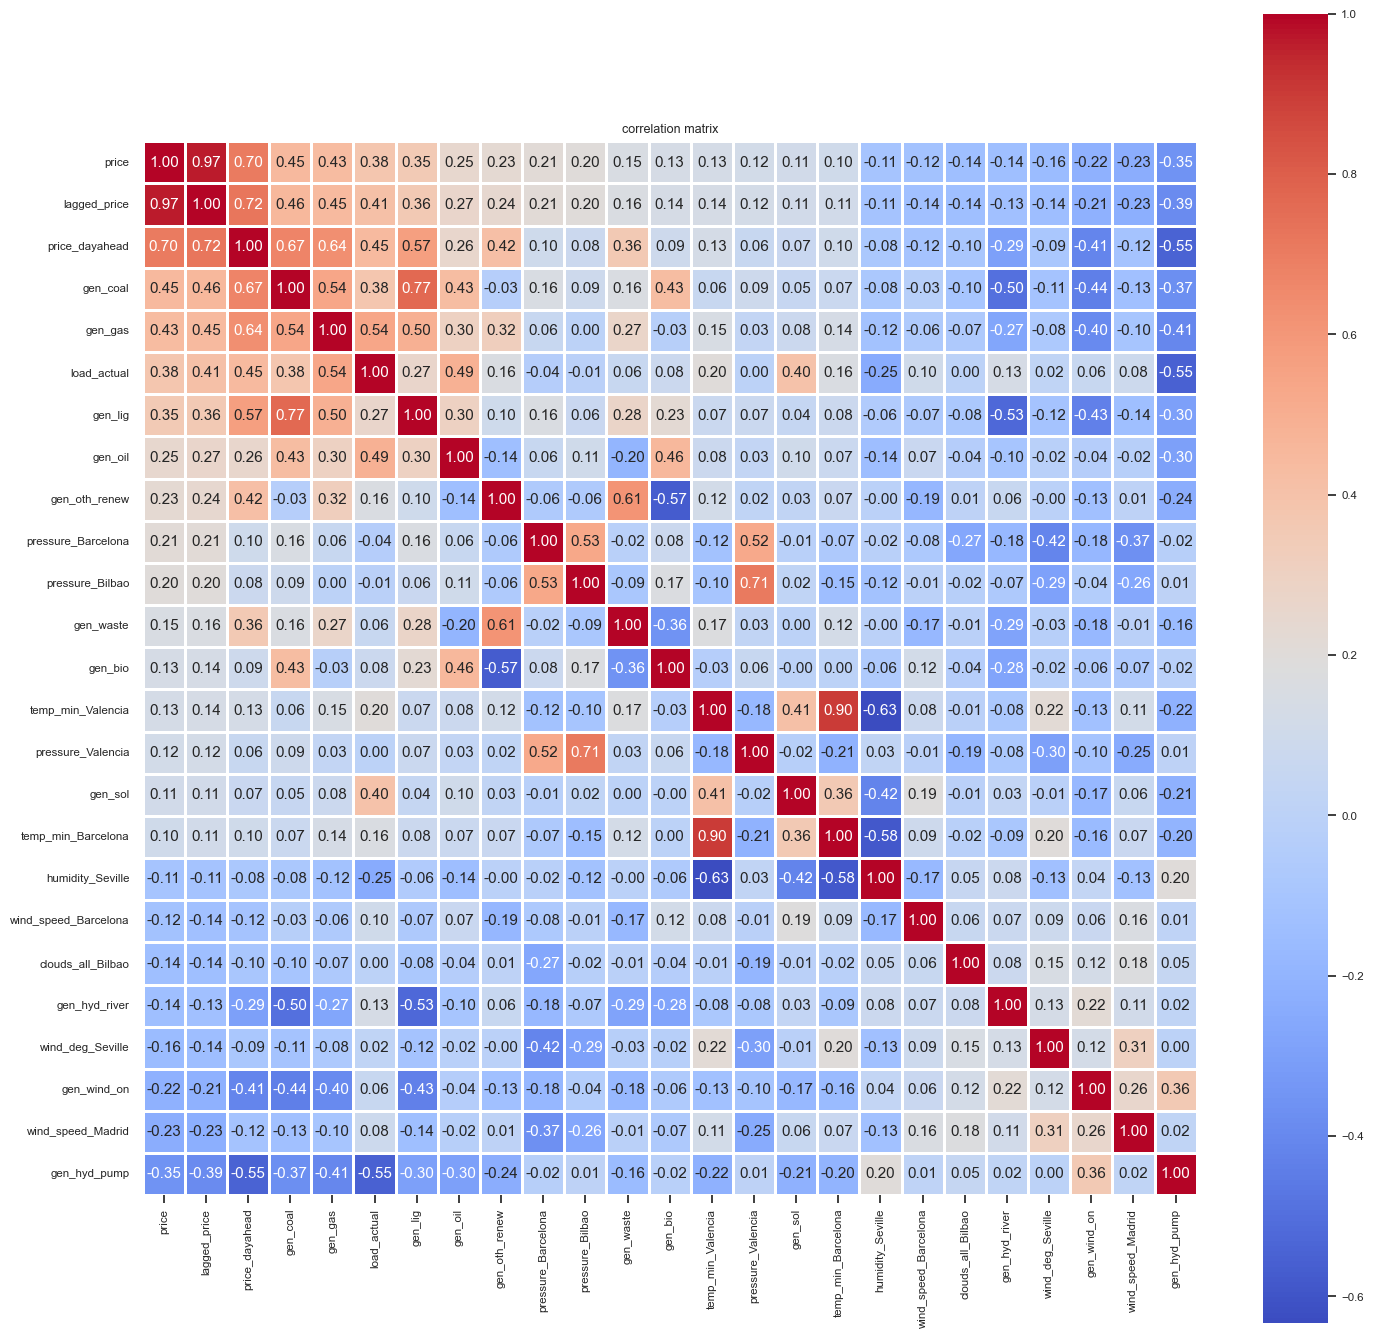

In [60]:
plt.figure(figsize = (17,17))
sns.set(font_scale=0.75)
ax = sns.heatmap(
    df_corr, 
    annot=True, 
    square=True, 
    linewidths=.75, 
    cmap="coolwarm", 
    fmt = ".2f", 
    annot_kws = {"size": 11}
)
ax.xaxis.tick_bottom()
plt.title("correlation matrix")
plt.show()

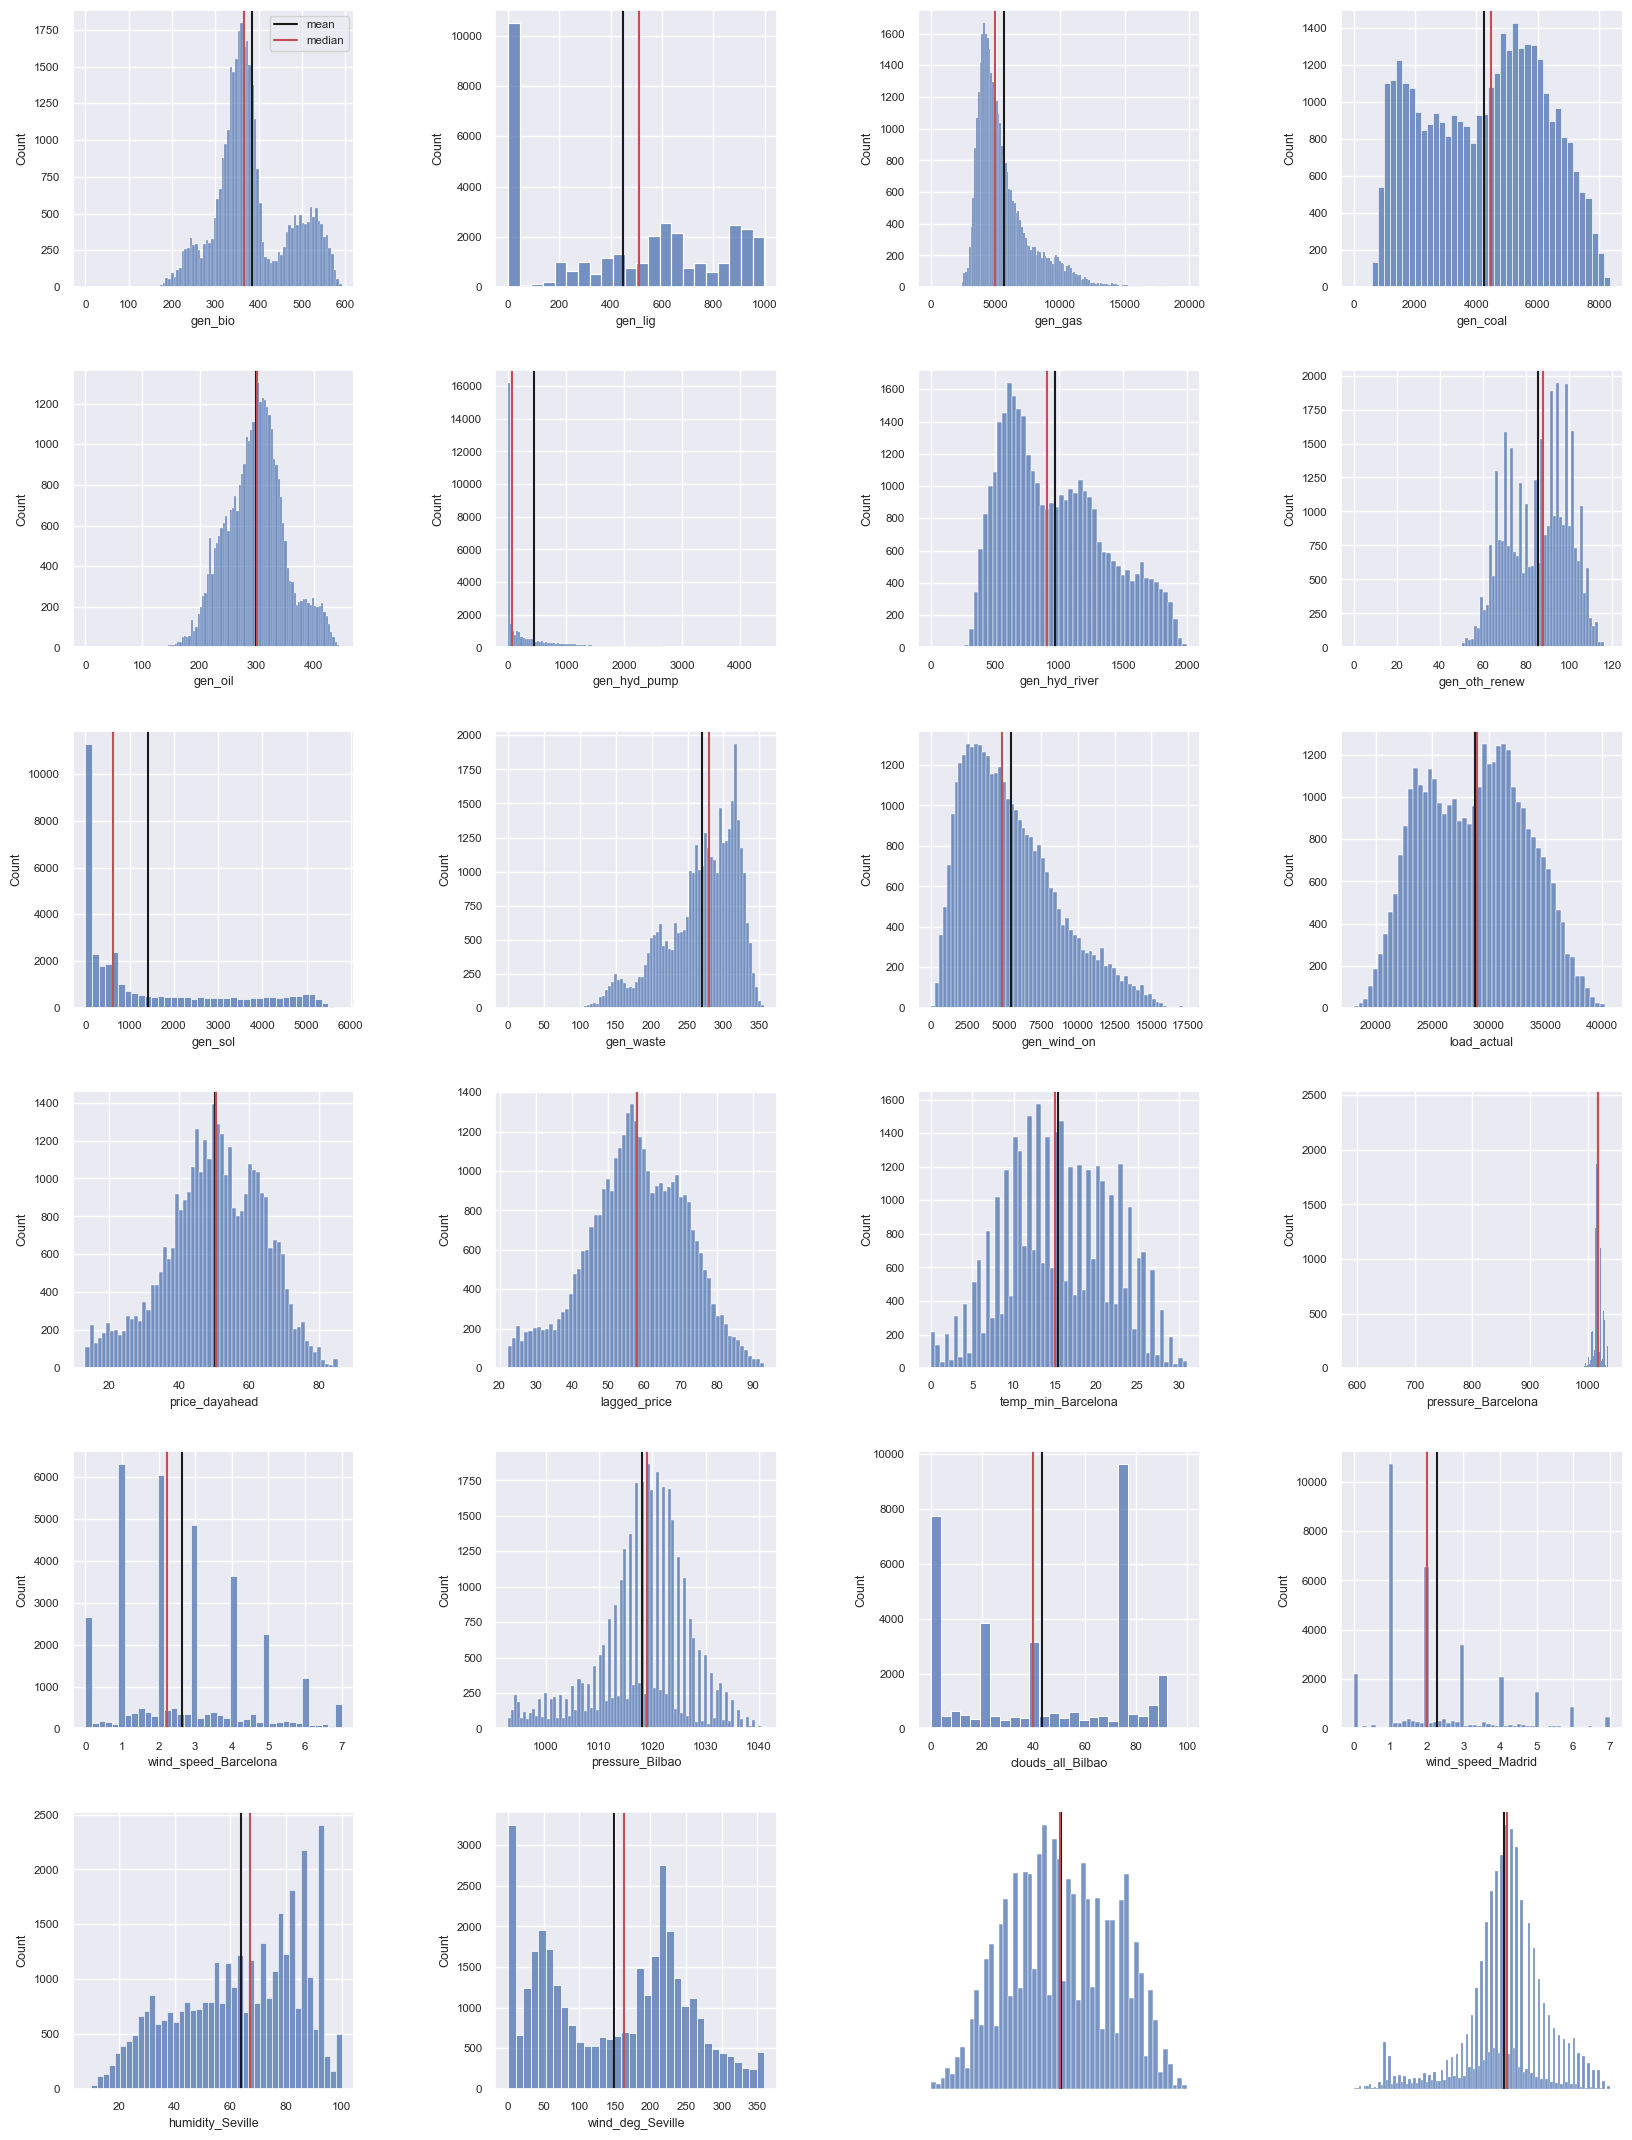

In [61]:
# Plot features distributions
X = X.filter(top_candidates)

rows = int(np.ceil(X.shape[1] / 4))
f, ax = plt.subplots(rows, 4, figsize=(20, rows*4.5), gridspec_kw={'wspace':0.5,'hspace':0.3})

ax = ax.ravel()

for i, col in enumerate(X):
    sns.histplot(X[col].astype(float), ax=ax[i], kde=False)
    ax[i].axvline(x=X[col].mean(), color='k', label='mean')
    ax[i].axvline(x=X[col].median(), color='r', label='median')
    
ax[0].legend();
ax[-2].axis('off')
ax[-1].axis('off');

### Feature Enrichment
- There are multiple strategies for enriching features to boost the achievable forecast accuracy of a model.
- This might include techniques like binning, linear combinations of some key features, laggin features, calculating moving average, exponential moing averages, etc.

In [62]:
def find_optimal_seasonal_period(time_series, max_period=None):
    if max_period is None:
        max_period = len(time_series) // 2

    # Perform seasonal decomposition using STL
    decomposition = seasonal_decompose(time_series, period=max_period)

    # Get the seasonal component
    seasonal_component = decomposition.seasonal.dropna()

    # Compute the periodogram
    n = len(seasonal_component)
    fft_values = np.abs(np.fft.fft(seasonal_component)) ** 2
    fft_values = fft_values[:n // 2]
    frequencies = np.fft.fftfreq(n, 1)
    frequencies = frequencies[:n // 2]

    # Find the index of the maximum frequency
    max_index = np.argmax(fft_values)
    # pprint(fft_values)

    # Calculate the optimal seasonal period
    optimal_period = int(1 / frequencies[max_index])

    # Plot the periodogram (optional)
    plt.plot(1 / frequencies, fft_values)
    plt.xlabel('Seasonal Period')
    plt.ylabel('Periodogram')
    plt.title('Periodogram of Seasonal Component')
    plt.show()

    return optimal_period

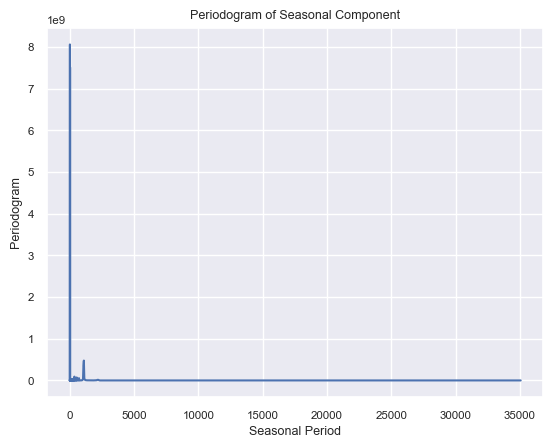

In [63]:
sp = find_optimal_seasonal_period(y.copy(), 24*3*30)

In [64]:
sp

12

In [65]:
lag_periods = list(range(1, sp//2 + 1)) + [sp * i for i in range(1, sp//2 + 1)] + [24*31, 24*365]
rolling_windows = [sp//2, sp, 2*sp]

In [66]:
lag_periods

[1, 2, 3, 4, 5, 6, 12, 24, 36, 48, 60, 72, 744, 8760]

In [67]:
rolling_windows

[6, 12, 24]

In [68]:
# Lagg Features
def lag_df(df_: pd.DataFrame, lag: int):
    df_[df_.columns] = df_[df_.columns].shift(lag, axis=0)
    
    return (
        df_
        .rename(columns=lambda x: f"{x}_lag_{lag}" if x in df_.columns else x)
        .fillna(method='bfill')
    )


# Simple rolling features
def rolling_df(df_: pd.DataFrame, window: int, agg_fun: str = 'mean'):
    if agg_fun == 'mean':
        df_[df_.columns] = df_.rolling(window=window).mean()
    elif agg_fun == 'std':
        df_[df_.columns] = df_.rolling(window=window).std()
    elif agg_fun == 'max':
        df_[df_.columns] = df_.rolling(window=window).max()
    elif agg_fun == 'min':
        df_[df_.columns] = df_.rolling(window=window).min()
    elif agg_fun == 'min_max':
        df_[df_.columns] = df_.rolling(window=window).max() - df_.rolling(window=window).min()
        
    return (
        df_
        .rename(columns=lambda x: f"{x}_sm_{agg_fun}_{window}" if x in df_.columns else x)
        .fillna(method='bfill')
    )


# Exponential Moving Average
def ema(df_: pd.DataFrame, window: int):
    # ewm(span=window, adjust=False)
    df_[df_.columns] = df_.ewm(span=window, adjust=False).mean()
    
    return (
        df_
        .rename(columns=lambda x: f"{x}_ema_{window}" if x in df_.columns else x)
        .fillna(method='bfill')
    )


# Temporal Embedding Features
def tef(df_: pd.DataFrame, dow: bool = True, dom: bool = True, hod: bool = True):
    # Day of Week
    if dow:
        df_['dow_sin'] = np.sin(2 * np.pi * df_.index.dayofweek / 7)
        df_['day_cos'] = np.cos(2 * np.pi * df_.index.dayofweek / 7)
    
    # Day of Month
    if dom:
        df_['dom_sin'] = np.sin(2 * np.pi * df_.index.day / 31)
        df_['dam_cos'] = np.cos(2 * np.pi * df_.index.day / 31)
        
    # Hour of Day
    if hod:
        df_['hod_sin'] = np.sin(2 * np.pi * df_.index.hour / 24)
        df_['hod_cos'] = np.cos(2 * np.pi * df_.index.hour / 24)
        
    return pd.concat([
        df_.filter(like='sin', axis=1), 
        df_.filter(like='cos', axis=1)
    ], axis=1)


# Time Based Features
def tbf(df_: pd.DataFrame):
    # Time-based Features
    df_['month'] = df_.index.month
    df_['day'] = df_.index.day
    df_['day_of_week'] = df_.index.dayofweek
    df_['hour'] = df_.index.hour
    
    return df_[['month', 'day', 'day_of_week', 'hour']]


# Holiday-based features
def extract_holidays(df_: pd.DataFrame):
    spain_holidays = holidays.CountryHoliday('ES', observed=True)
    df_['is_holiday'] = df_.index.to_series().apply(lambda x: x.date() in spain_holidays)
    
    return df_[['is_holiday']]


# Seasonal Decomposition
def extract_stl(target: pd.DataFrame, seasonal_period: int):
    if seasonal_period % 2 == 0:
        seasonal_period += 1
        
    stl = STL(target.values, period=seasonal_period)
    result = stl.fit()
    
    stl_df = pd.concat(
        [pd.Series(result.trend), pd.Series(result.seasonal), pd.Series(result.resid)], axis=1
    ).rename(columns={
        0: 'stl_trend',
        1: 'stl_season',
        2: 'stl_resid'
    })
    stl_df.index = target.index
    
    return stl_df

In [69]:
lag_df = pd.concat(
    [lag_df(X.copy(), lag=lag) for lag in lag_periods],
    axis=1
)

In [70]:
lag_df.tail()

gen_bio_lag_1  gen_lig_lag_1  gen_gas_lag_1  \
2018-12-31 19:00:00          293.0            0.0         7593.0   
2018-12-31 20:00:00          297.0            0.0         7634.0   
2018-12-31 21:00:00          296.0            0.0         7241.0   
2018-12-31 22:00:00          292.0            0.0         7025.0   
2018-12-31 23:00:00          293.0            0.0         6562.0   

                     gen_coal_lag_1  gen_oil_lag_1  gen_hyd_pump_lag_1  \
2018-12-31 19:00:00          2604.0          178.0                 1.0   
2018-12-31 20:00:00          2628.0          178.0                 1.0   
2018-12-31 21:00:00          2566.0          174.0                 1.0   
2018-12-31 22:00:00          2422.0          168.0                50.0   
2018-12-31 23:00:00          2293.0          163.0               108.0   

                     gen_hyd_river_lag_1  gen_oth_renew_lag_1  gen_sol_lag_1  \
2018-12-31 19:00:00               1131.0                 92.0          266.0   
2018-12-31 20:00:00               1135.0                 95.0           85.0   
2018-12-31 21:00:00               1172.0                 95.0           33.0   
2018-12-31 22:00:00               1148.0                 94.0           31.0   
2018-12-31 23:00:00               1128.0                 93.0           31.0   

                     gen_waste_lag_1  gen_wind_on_lag_1  load_actual_lag_1  \
2018-12-31 19:00:00            289.0             2952.0            29592.0   
2018-12-31 20:00:00            277.0             3113.0            30653.0   
2018-12-31 21:00:00            280.0             3288.0            29735.0   
2018-12-31 22:00:00            286.0             3503.0            28071.0   
2018-12-31 23:00:00            287.0             3586.0            25801.0   

                     price_dayahead_lag_1  lagged_price_lag_1  \
2018-12-31 19:00:00                 68.58               77.61   
2018-12-31 20:00:00                 68.85               77.02   
2018-12-31 21:00:00                 68.40               76.16   
2018-12-31 22:00:00                 66.88               74.30   
2018-12-31 23:00:00                 63.93               69.89   

                     temp_min_Barcelona_lag_1  pressure_Barcelona_lag_1  \
2018-12-31 19:00:00                      13.0                    1027.0   
2018-12-31 20:00:00                       9.0                    1027.0   
2018-12-31 21:00:00                       8.0                    1027.0   
2018-12-31 22:00:00                       7.0                    1028.0   
2018-12-31 23:00:00                       5.0                    1028.0   

                     wind_speed_Barcelona_lag_1  pressure_Bilbao_lag_1  \
2018-12-31 19:00:00                         3.0                 1033.0   
2018-12-31 20:00:00                         1.0                 1033.0   
2018-12-31 21:00:00                         3.0                 1034.0   
2018-12-31 22:00:00                         4.0                 1034.0   
2018-12-31 23:00:00                         5.0                 1034.0   

                     clouds_all_Bilbao_lag_1  wind_speed_Madrid_lag_1  \
2018-12-31 19:00:00                      0.0                      1.0   
2018-12-31 20:00:00                      0.0                      1.0   
2018-12-31 21:00:00                      0.0                      1.0   
2018-12-31 22:00:00                      0.0                      1.0   
2018-12-31 23:00:00                      0.0                      2.0   

                     humidity_Seville_lag_1  wind_deg_Seville_lag_1  \
2018-12-31 19:00:00                    42.0                    60.0   
2018-12-31 20:00:00                    54.0                    30.0   
2018-12-31 21:00:00                    62.0                    30.0   
2018-12-31 22:00:00                    58.0                    50.0   
2018-12-31 23:00:00                    57.0                    60.0   

                     temp_min_Valencia_lag_1  pressure_Valencia_

In [71]:
sma_df = pd.concat(
    [rolling_df(X.copy(), window=window, agg_fun='mean') for window in rolling_windows],
    axis=1
)

In [72]:
sma_df.tail()

gen_bio_sm_mean_6  gen_lig_sm_mean_6  gen_gas_sm_mean_6  \
2018-12-31 19:00:00         296.666667                0.0        6781.333333   
2018-12-31 20:00:00         296.500000                0.0        6977.833333   
2018-12-31 21:00:00         296.000000                0.0        7127.333333   
2018-12-31 22:00:00         294.833333                0.0        7157.833333   
2018-12-31 23:00:00         293.500000                0.0        7163.500000   

                     gen_coal_sm_mean_6  gen_oil_sm_mean_6  \
2018-12-31 19:00:00         2586.166667         183.500000   
2018-12-31 20:00:00         2564.166667         177.166667   
2018-12-31 21:00:00         2551.000000         175.500000   
2018-12-31 22:00:00         2516.000000         173.000000   
2018-12-31 23:00:00         2446.500000         170.666667   

                     gen_hyd_pump_sm_mean_6  gen_hyd_river_sm_mean_6  \
2018-12-31 19:00:00              172.333333              1084.500000   
2018-12-31 20:00:00              131.500000              1104.333333   
2018-12-31 21:00:00               83.333333              1120.333333   
2018-12-31 22:00:00               47.500000              1133.666667   
2018-12-31 23:00:00               44.833333              1130.500000   

                     gen_oth_renew_sm_mean_6  gen_sol_sm_mean_6  \
2018-12-31 19:00:00                94.000000        2024.833333   
2018-12-31 20:00:00                94.166667        1390.166667   
2018-12-31 21:00:00                94.500000         779.833333   
2018-12-31 22:00:00                94.000000         294.333333   
2018-12-31 23:00:00                93.500000          79.500000   

                     gen_waste_sm_mean_6  gen_wind_on_sm_mean_6  \
2018-12-31 19:00:00           289.500000            2567.333333   
2018-12-31 20:00:00           287.166667            2733.833333   
2018-12-31 21:00:00           287.000000            2945.500000   
2018-12-31 22:00:00           285.833333            3165.333333   
2018-12-31 23:00:00           284.333333            3348.833333   

                     load_actual_sm_mean_6  price_dayahead_sm_mean_6  \
2018-12-31 19:00:00           28071.500000                 66.565000   
2018-12-31 20:00:00           28362.666667                 67.136667   
2018-12-31 21:00:00           28539.666667                 67.586667   
2018-12-31 22:00:00           28431.666667                 67.441667   
2018-12-31 23:00:00           28051.166667                 66.818333   

                     lagged_price_sm_mean_6  temp_min_Barcelona_sm_mean_6  \
2018-12-31 19:00:00               73.986667                     13.666667   
2018-12-31 20:00:00               74.688333                     12.500000   
2018-12-31 21:00:00               75.263333                     11.166667   
2018-12-31 22:00:00               75.018333                      9.500000   
2018-12-31 23:00:00               74.143333                      7.666667   

                     pressure_Barcelona_sm_mean_6  \
2018-12-31 19:00:00                   1027.166667   
2018-12-31 20:00:00                   1027.000000   
2018-12-31 21:00:00                   1027.166667   
2018-12-31 22:00:00                   1027.333333   
2018-12-31 23:00:00                   1027.500000   

                     wind_speed_Barcelona_sm_mean_6  \
2018-12-31 19:00:00                        2.333333   
2018-12-31 20:00:00                        2.500000   
2018-12-31 21:00:00                        2.833333   
2018-12-31 22:00:00                        3.166667   
2018-12-31 23:00:00                        3.500000   

                     pressure_Bilbao_sm_mean_6  clouds_all_Bilbao_sm_mean_6  \
2018-12-31 19:00:00                1033.166667                     3.333333   
2018-12-31 20:00:00                1033.166667                     0.000000   
2018-12-31 21:00:00                1033.333333                     0.000000   
2018-12-31 22:00:00                1033.500000                    

In [73]:
sm_std_df = pd.concat(
    [rolling_df(X.copy(), window=window, agg_fun='std') for window in rolling_windows],
    axis=1
)

In [74]:
sm_std_df.tail()

gen_bio_sm_std_6  gen_lig_sm_std_6  gen_gas_sm_std_6  \
2018-12-31 19:00:00          2.422120               0.0        707.707190   
2018-12-31 20:00:00          2.428992               0.0        627.124682   
2018-12-31 21:00:00          3.033150               0.0        471.663722   
2018-12-31 22:00:00          2.483277               0.0        416.257332   
2018-12-31 23:00:00          2.588436               0.0        412.125588   

                     gen_coal_sm_std_6  gen_oil_sm_std_6  \
2018-12-31 19:00:00          75.835128         13.967820   
2018-12-31 20:00:00          52.442031          1.602082   
2018-12-31 21:00:00          76.068390          3.987480   
2018-12-31 22:00:00         131.028241          6.196773   
2018-12-31 23:00:00         187.014171          6.976150   

                     gen_hyd_pump_sm_std_6  gen_hyd_river_sm_std_6  \
2018-12-31 19:00:00             152.938768               40.262886   
2018-12-31 20:00:00             161.787206               49.818337   
2018-12-31 21:00:00             126.918346               44.813688   
2018-12-31 22:00:00              56.578264               27.572934   
2018-12-31 23:00:00              52.480155               34.168699   

                     gen_oth_renew_sm_std_6  gen_sol_sm_std_6  \
2018-12-31 19:00:00                1.673320       1689.931764   
2018-12-31 20:00:00                1.722401       1583.128222   
2018-12-31 21:00:00                1.378405       1169.677463   
2018-12-31 22:00:00                1.264911        510.607351   
2018-12-31 23:00:00                1.378405         93.841888   

                     gen_waste_sm_std_6  gen_wind_on_sm_std_6  \
2018-12-31 19:00:00            7.007139            380.911888   
2018-12-31 20:00:00            7.521081            447.443143   
2018-12-31 21:00:00            7.536577            463.247990   
2018-12-31 22:00:00            6.735478            382.860636   
2018-12-31 23:00:00            4.718757            278.608985   

                     load_actual_sm_std_6  price_dayahead_sm_std_6  \
2018-12-31 19:00:00           1704.269316                 2.131523   
2018-12-31 20:00:00           1831.625580                 2.077466   
2018-12-31 21:00:00           1722.727102                 1.528943   
2018-12-31 22:00:00           1892.002502                 1.852991   
2018-12-31 23:00:00           2448.471231                 2.216893   

                     lagged_price_sm_std_6  temp_min_Barcelona_sm_std_6  \
2018-12-31 19:00:00               2.984055                     2.422120   
2018-12-31 20:00:00               2.903249                     3.209361   
2018-12-31 21:00:00               2.261793                     3.600926   
2018-12-31 22:00:00               2.787654                     3.781534   
2018-12-31 23:00:00               3.482853                     3.204164   

                     pressure_Barcelona_sm_std_6  \
2018-12-31 19:00:00                     0.408248   
2018-12-31 20:00:00                     0.000000   
2018-12-31 21:00:00                     0.408248   
2018-12-31 22:00:00                     0.516398   
2018-12-31 23:00:00                     0.547723   

                     wind_speed_Barcelona_sm_std_6  pressure_Bilbao_sm_std_6  \
2018-12-31 19:00:00                       0.816497                  0.408248   
2018-12-31 20:00:00                       0.836660                  0.408248   
2018-12-31 21:00:00                       0.983192                  0.516398   
2018-12-31 22:00:00                       1.329160                  0.547723   
2018-12-31 23:00:00                       1.516575                  0.516398   

                     clouds_all_Bilbao_sm_std_6  wind_speed_Madrid_sm_std_6  \
2018-12-31 19:00:00                    8.164966                    0.408248   
2018-12-31 20:00:00                    0.000000                    0.000000   
2018-12-31 21:00:00                    0.000000                    0.000000   
2018-12-31 2

In [75]:
sm_max_df = pd.concat(
    [rolling_df(X.copy(), window=window, agg_fun='max') for window in rolling_windows],
    axis=1
)

In [76]:
sm_max_df.tail()

gen_bio_sm_max_6  gen_lig_sm_max_6  gen_gas_sm_max_6  \
2018-12-31 19:00:00             300.0               0.0            7634.0   
2018-12-31 20:00:00             300.0               0.0            7634.0   
2018-12-31 21:00:00             300.0               0.0            7634.0   
2018-12-31 22:00:00             298.0               0.0            7634.0   
2018-12-31 23:00:00             297.0               0.0            7634.0   

                     gen_coal_sm_max_6  gen_oil_sm_max_6  \
2018-12-31 19:00:00             2698.0             212.0   
2018-12-31 20:00:00             2628.0             178.0   
2018-12-31 21:00:00             2628.0             178.0   
2018-12-31 22:00:00             2628.0             178.0   
2018-12-31 23:00:00             2628.0             178.0   

                     gen_hyd_pump_sm_max_6  gen_hyd_river_sm_max_6  \
2018-12-31 19:00:00                  339.0                  1135.0   
2018-12-31 20:00:00                  339.0                  1172.0   
2018-12-31 21:00:00                  323.0                  1172.0   
2018-12-31 22:00:00                  124.0                  1172.0   
2018-12-31 23:00:00                  108.0                  1172.0   

                     gen_oth_renew_sm_max_6  gen_sol_sm_max_6  \
2018-12-31 19:00:00                    96.0            3841.0   
2018-12-31 20:00:00                    96.0            3693.0   
2018-12-31 21:00:00                    96.0            2944.0   
2018-12-31 22:00:00                    95.0            1320.0   
2018-12-31 23:00:00                    95.0             266.0   

                     gen_waste_sm_max_6  gen_wind_on_sm_max_6  \
2018-12-31 19:00:00               296.0                3113.0   
2018-12-31 20:00:00               296.0                3288.0   
2018-12-31 21:00:00               296.0                3503.0   
2018-12-31 22:00:00               296.0                3586.0   
2018-12-31 23:00:00               289.0                3651.0   

                     load_actual_sm_max_6  price_dayahead_sm_max_6  \
2018-12-31 19:00:00               30653.0                    68.85   
2018-12-31 20:00:00               30653.0                    68.85   
2018-12-31 21:00:00               30653.0                    68.85   
2018-12-31 22:00:00               30653.0                    68.85   
2018-12-31 23:00:00               30653.0                    68.85   

                     lagged_price_sm_max_6  temp_min_Barcelona_sm_max_6  \
2018-12-31 19:00:00                  77.61                         15.0   
2018-12-31 20:00:00                  77.61                         15.0   
2018-12-31 21:00:00                  77.61                         15.0   
2018-12-31 22:00:00                  77.61                         15.0   
2018-12-31 23:00:00                  77.61                         13.0   

                     pressure_Barcelona_sm_max_6  \
2018-12-31 19:00:00                       1028.0   
2018-12-31 20:00:00                       1027.0   
2018-12-31 21:00:00                       1028.0   
2018-12-31 22:00:00                       1028.0   
2018-12-31 23:00:00                       1028.0   

                     wind_speed_Barcelona_sm_max_6  pressure_Bilbao_sm_max_6  \
2018-12-31 19:00:00                            3.0                    1034.0   
2018-12-31 20:00:00                            3.0                    1034.0   
2018-12-31 21:00:00                            4.0                    1034.0   
2018-12-31 22:00:00                            5.0                    1034.0   
2018-12-31 23:00:00                            5.0                    1034.0   

                     clouds_all_Bilbao_sm_max_6  wind_speed_Madrid_sm_max_6  \
2018-12-31 19:00:00                        20.0                         1.0   
2018-12-31 20:00:00                         0.0                         1.0   
2018-12-31 21:00:00                         0.0                         1.0   
2018-12-31 2

In [77]:
sm_min_df = pd.concat(
    [rolling_df(X.copy(), window=window, agg_fun='min') for window in rolling_windows],
    axis=1
)

In [78]:
sm_min_df.tail()

gen_bio_sm_min_6  gen_lig_sm_min_6  gen_gas_sm_min_6  \
2018-12-31 19:00:00             293.0               0.0            6062.0   
2018-12-31 20:00:00             293.0               0.0            6128.0   
2018-12-31 21:00:00             292.0               0.0            6379.0   
2018-12-31 22:00:00             292.0               0.0            6562.0   
2018-12-31 23:00:00             290.0               0.0            6562.0   

                     gen_coal_sm_min_6  gen_oil_sm_min_6  \
2018-12-31 19:00:00             2501.0             177.0   
2018-12-31 20:00:00             2501.0             174.0   
2018-12-31 21:00:00             2422.0             168.0   
2018-12-31 22:00:00             2293.0             163.0   
2018-12-31 23:00:00             2166.0             163.0   

                     gen_hyd_pump_sm_min_6  gen_hyd_river_sm_min_6  \
2018-12-31 19:00:00                    1.0                  1048.0   
2018-12-31 20:00:00                    1.0                  1048.0   
2018-12-31 21:00:00                    1.0                  1048.0   
2018-12-31 22:00:00                    1.0                  1088.0   
2018-12-31 23:00:00                    1.0                  1069.0   

                     gen_oth_renew_sm_min_6  gen_sol_sm_min_6  \
2018-12-31 19:00:00                    92.0              85.0   
2018-12-31 20:00:00                    92.0              33.0   
2018-12-31 21:00:00                    92.0              31.0   
2018-12-31 22:00:00                    92.0              31.0   
2018-12-31 23:00:00                    92.0              31.0   

                     gen_waste_sm_min_6  gen_wind_on_sm_min_6  \
2018-12-31 19:00:00               277.0                2233.0   
2018-12-31 20:00:00               277.0                2233.0   
2018-12-31 21:00:00               277.0                2267.0   
2018-12-31 22:00:00               277.0                2550.0   
2018-12-31 23:00:00               277.0                2952.0   

                     load_actual_sm_min_6  price_dayahead_sm_min_6  \
2018-12-31 19:00:00               26449.0                    64.18   
2018-12-31 20:00:00               26449.0                    64.18   
2018-12-31 21:00:00               26449.0                    64.80   
2018-12-31 22:00:00               25801.0                    63.93   
2018-12-31 23:00:00               24455.0                    63.93   

                     lagged_price_sm_min_6  temp_min_Barcelona_sm_min_6  \
2018-12-31 19:00:00                  70.85                          9.0   
2018-12-31 20:00:00                  70.85                          8.0   
2018-12-31 21:00:00                  71.36                          7.0   
2018-12-31 22:00:00                  69.89                          5.0   
2018-12-31 23:00:00                  69.88                          4.0   

                     pressure_Barcelona_sm_min_6  \
2018-12-31 19:00:00                       1027.0   
2018-12-31 20:00:00                       1027.0   
2018-12-31 21:00:00                       1027.0   
2018-12-31 22:00:00                       1027.0   
2018-12-31 23:00:00                       1027.0   

                     wind_speed_Barcelona_sm_min_6  pressure_Bilbao_sm_min_6  \
2018-12-31 19:00:00                            1.0                    1033.0   
2018-12-31 20:00:00                            1.0                    1033.0   
2018-12-31 21:00:00                            1.0                    1033.0   
2018-12-31 22:00:00                            1.0                    1033.0   
2018-12-31 23:00:00                            1.0                    1033.0   

                     clouds_all_Bilbao_sm_min_6  wind_speed_Madrid_sm_min_6  \
2018-12-31 19:00:00                         0.0                         0.0   
2018-12-31 20:00:00                         0.0                         1.0   
2018-12-31 21:00:00                         0.0                         1.0   
2018-12-31 2

In [79]:
sm_min_max_df = pd.concat(
    [rolling_df(X.copy(), window=window, agg_fun='min_max') for window in rolling_windows],
    axis=1
)

In [80]:
sm_min_max_df.tail()

gen_bio_sm_min_max_6  gen_lig_sm_min_max_6  \
2018-12-31 19:00:00                   7.0                   0.0   
2018-12-31 20:00:00                   7.0                   0.0   
2018-12-31 21:00:00                   8.0                   0.0   
2018-12-31 22:00:00                   6.0                   0.0   
2018-12-31 23:00:00                   7.0                   0.0   

                     gen_gas_sm_min_max_6  gen_coal_sm_min_max_6  \
2018-12-31 19:00:00                1572.0                  197.0   
2018-12-31 20:00:00                1506.0                  127.0   
2018-12-31 21:00:00                1255.0                  206.0   
2018-12-31 22:00:00                1072.0                  335.0   
2018-12-31 23:00:00                1072.0                  462.0   

                     gen_oil_sm_min_max_6  gen_hyd_pump_sm_min_max_6  \
2018-12-31 19:00:00                  35.0                      338.0   
2018-12-31 20:00:00                   4.0                      338.0   
2018-12-31 21:00:00                  10.0                      322.0   
2018-12-31 22:00:00                  15.0                      123.0   
2018-12-31 23:00:00                  15.0                      107.0   

                     gen_hyd_river_sm_min_max_6  gen_oth_renew_sm_min_max_6  \
2018-12-31 19:00:00                        87.0                         4.0   
2018-12-31 20:00:00                       124.0                         4.0   
2018-12-31 21:00:00                       124.0                         4.0   
2018-12-31 22:00:00                        84.0                         3.0   
2018-12-31 23:00:00                       103.0                         3.0   

                     gen_sol_sm_min_max_6  gen_waste_sm_min_max_6  \
2018-12-31 19:00:00                3756.0                    19.0   
2018-12-31 20:00:00                3660.0                    19.0   
2018-12-31 21:00:00                2913.0                    19.0   
2018-12-31 22:00:00                1289.0                    19.0   
2018-12-31 23:00:00                 235.0                    12.0   

                     gen_wind_on_sm_min_max_6  load_actual_sm_min_max_6  \
2018-12-31 19:00:00                     880.0                    4204.0   
2018-12-31 20:00:00                    1055.0                    4204.0   
2018-12-31 21:00:00                    1236.0                    4204.0   
2018-12-31 22:00:00                    1036.0                    4852.0   
2018-12-31 23:00:00                     699.0                    6198.0   

                     price_dayahead_sm_min_max_6  lagged_price_sm_min_max_6  \
2018-12-31 19:00:00                         4.67                       6.76   
2018-12-31 20:00:00                         4.67                       6.76   
2018-12-31 21:00:00                         4.05                       6.25   
2018-12-31 22:00:00                         4.92                       7.72   
2018-12-31 23:00:00                         4.92                       7.73   

                     temp_min_Barcelona_sm_min_max_6  \
2018-12-31 19:00:00                              6.0   
2018-12-31 20:00:00                              7.0   
2018-12-31 21:00:00                              8.0   
2018-12-31 22:00:00                             10.0   
2018-12-31 23:00:00                              9.0   

                     pressure_Barcelona_sm_min_max_6  \
2018-12-31 19:00:00                              1.0   
2018-12-31 20:00:00                              0.0   
2018-12-31 21:00:00                              1.0   
2018-12-31 22:00:00                              1.0   
2018-12-31 23:00:00                              1.0   

                     wind_speed_Barcelona_sm_min_max_6  \
2018-12-31 19:00:00                                2.0   
2018-12-31 20:00:00                                2.0   
2018-12-31 21:00:00                                3.0   
2018-12-31 22:00:00                                4.0

In [81]:
ema_df = pd.concat(
    [ema(X.copy(), window=window) for window in rolling_windows],
    axis=1
)

In [82]:
ema_df.tail()

gen_bio_ema_6  gen_lig_ema_6  gen_gas_ema_6  \
2018-12-31 19:00:00     297.022676   7.056031e-08    7006.626434   
2018-12-31 20:00:00     296.730483   5.040022e-08    7073.590310   
2018-12-31 21:00:00     295.378917   3.600016e-08    7059.707364   
2018-12-31 22:00:00     294.699226   2.571440e-08    6917.505260   
2018-12-31 23:00:00     293.356590   1.836743e-08    6919.932329   

                     gen_coal_ema_6  gen_oil_ema_6  gen_hyd_pump_ema_6  \
2018-12-31 19:00:00     2582.974879     184.192825           98.600949   
2018-12-31 20:00:00     2578.124914     181.280589           70.714964   
2018-12-31 21:00:00     2533.517796     177.486135           64.796403   
2018-12-31 22:00:00     2464.798425     173.347239           77.140288   
2018-12-31 23:00:00     2379.427447     170.390885           85.957348   

                     gen_hyd_river_ema_6  gen_oth_renew_ema_6  gen_sol_ema_6  \
2018-12-31 19:00:00          1096.404382            93.912965    1407.189121   
2018-12-31 20:00:00          1118.003130            94.223546    1014.563658   
2018-12-31 21:00:00          1126.573664            94.159676     733.545470   
2018-12-31 22:00:00          1126.981189            93.828340     532.818193   
2018-12-31 23:00:00          1110.415135            93.305957     389.441566   

                     gen_waste_ema_6  gen_wind_on_ema_6  load_actual_ema_6  \
2018-12-31 19:00:00       287.342080        2750.428702       28663.029723   
2018-12-31 20:00:00       285.244343        2904.020502       28969.306945   
2018-12-31 21:00:00       285.460245        3075.157501       28712.647818   
2018-12-31 22:00:00       285.900175        3221.112501       27880.748441   
2018-12-31 23:00:00       286.214411        3343.937501       26901.963172   

                     price_dayahead_ema_6  lagged_price_ema_6  \
2018-12-31 19:00:00             66.985960           74.624238   
2018-12-31 20:00:00             67.389971           75.063027   
2018-12-31 21:00:00             67.244265           74.845019   
2018-12-31 22:00:00             66.297332           73.429299   
2018-12-31 23:00:00             65.718094           72.415214   

                     temp_min_Barcelona_ema_6  pressure_Barcelona_ema_6  \
2018-12-31 19:00:00                 11.850987               1027.333533   
2018-12-31 20:00:00                 10.750705               1027.238238   
2018-12-31 21:00:00                  9.679075               1027.455884   
2018-12-31 22:00:00                  8.342196               1027.611346   
2018-12-31 23:00:00                  7.101569               1027.722390   

                     wind_speed_Barcelona_ema_6  pressure_Bilbao_ema_6  \
2018-12-31 19:00:00                    2.528257            1033.252446   
2018-12-31 20:00:00                    2.663040            1033.466033   
2018-12-31 21:00:00                    3.045029            1033.618595   
2018-12-31 22:00:00                    3.603592            1033.727568   
2018-12-31 23:00:00                    4.002566            1033.805406   

                     clouds_all_Bilbao_ema_6  wind_speed_Madrid_ema_6  \
2018-12-31 19:00:00                10.837404                 0.900196   
2018-12-31 20:00:00                 7.741003                 0.928712   
2018-12-31 21:00:00                 5.529288                 0.949080   
2018-12-31 22:00:00                 3.949491                 1.249343   
2018-12-31 23:00:00                 2.821065                 1.178102   

                     humidity_Seville_ema_6  wind_deg_Seville_ema_6  \
2018-12-31 19:00:00               51.592962               49.018943   
2018-12-31 20:00:00               54.566402               43.584960   
2018-12-31 21:00:00               55.547430               45.417828   
2018-12-31 22:00:00               55.962450               49.584163   
2018-12-31 23:00:00               59.973178               49.702974   

                     temp_min_Valencia_ema_6  pressure_Valencia_

In [83]:
tef_df = tef(X.copy())

In [84]:
tef_df.tail()

dow_sin       dom_sin   hod_sin  day_cos  dam_cos  \
2018-12-31 19:00:00      0.0 -2.449294e-16 -0.965926      1.0      1.0   
2018-12-31 20:00:00      0.0 -2.449294e-16 -0.866025      1.0      1.0   
2018-12-31 21:00:00      0.0 -2.449294e-16 -0.707107      1.0      1.0   
2018-12-31 22:00:00      0.0 -2.449294e-16 -0.500000      1.0      1.0   
2018-12-31 23:00:00      0.0 -2.449294e-16 -0.258819      1.0      1.0   

                      hod_cos  
2018-12-31 19:00:00  0.258819  
2018-12-31 20:00:00  0.500000  
2018-12-31 21:00:00  0.707107  
2018-12-31 22:00:00  0.866025  
2018-12-31 23:00:00  0.965926

In [85]:
tbf_df = tbf(X.copy())

In [86]:
tbf_df.tail()

month  day  day_of_week  hour
2018-12-31 19:00:00     12   31            0    19
2018-12-31 20:00:00     12   31            0    20
2018-12-31 21:00:00     12   31            0    21
2018-12-31 22:00:00     12   31            0    22
2018-12-31 23:00:00     12   31            0    23

In [87]:
holiday_df = extract_holidays(X.copy())

In [88]:
holiday_df.tail()

is_holiday
2018-12-31 19:00:00       False
2018-12-31 20:00:00       False
2018-12-31 21:00:00       False
2018-12-31 22:00:00       False
2018-12-31 23:00:00       False

In [89]:
stl_df = extract_stl(target=X['lagged_price'], seasonal_period=sp)

In [90]:
stl_df.tail()

stl_trend  stl_season  stl_resid
2018-12-31 19:00:00  71.543635   -1.551516   7.027881
2018-12-31 20:00:00  71.662625   -1.281161   5.778536
2018-12-31 21:00:00  71.774239    0.227302   2.298459
2018-12-31 22:00:00  71.877259    0.774950  -2.762209
2018-12-31 23:00:00  71.970787    1.328205  -3.418992

In [91]:
# Concatenate extracted DataFrames
X = pd.concat([
    X, lag_df, sma_df, sm_std_df, sm_max_df, sm_min_df, 
    sm_min_max_df, ema_df, tef_df, tbf_df, holiday_df, stl_df
], axis=1)

In [92]:
X.tail()

gen_bio  gen_lig  gen_gas  gen_coal  gen_oil  \
2018-12-31 19:00:00    297.0      0.0   7634.0    2628.0    178.0   
2018-12-31 20:00:00    296.0      0.0   7241.0    2566.0    174.0   
2018-12-31 21:00:00    292.0      0.0   7025.0    2422.0    168.0   
2018-12-31 22:00:00    293.0      0.0   6562.0    2293.0    163.0   
2018-12-31 23:00:00    290.0      0.0   6926.0    2166.0    163.0   

                     gen_hyd_pump  gen_hyd_river  gen_oth_renew  gen_sol  \
2018-12-31 19:00:00           1.0         1135.0           95.0     85.0   
2018-12-31 20:00:00           1.0         1172.0           95.0     33.0   
2018-12-31 21:00:00          50.0         1148.0           94.0     31.0   
2018-12-31 22:00:00         108.0         1128.0           93.0     31.0   
2018-12-31 23:00:00         108.0         1069.0           92.0     31.0   

                     gen_waste  gen_wind_on  load_actual  price_dayahead  \
2018-12-31 19:00:00      277.0       3113.0      30653.0           68.85   
2018-12-31 20:00:00      280.0       3288.0      29735.0           68.40   
2018-12-31 21:00:00      286.0       3503.0      28071.0           66.88   
2018-12-31 22:00:00      287.0       3586.0      25801.0           63.93   
2018-12-31 23:00:00      287.0       3651.0      24455.0           64.27   

                     lagged_price  temp_min_Barcelona  pressure_Barcelona  \
2018-12-31 19:00:00         77.02                 9.0              1027.0   
2018-12-31 20:00:00         76.16                 8.0              1027.0   
2018-12-31 21:00:00         74.30                 7.0              1028.0   
2018-12-31 22:00:00         69.89                 5.0              1028.0   
2018-12-31 23:00:00         69.88                 4.0              1028.0   

                     wind_speed_Barcelona  pressure_Bilbao  clouds_all_Bilbao  \
2018-12-31 19:00:00                   1.0           1033.0                0.0   
2018-12-31 20:00:00                   3.0           1034.0                0.0   
2018-12-31 21:00:00                   4.0           1034.0                0.0   
2018-12-31 22:00:00                   5.0           1034.0                0.0   
2018-12-31 23:00:00                   5.0           1034.0                0.0   

                     wind_speed_Madrid  humidity_Seville  wind_deg_Seville  \
2018-12-31 19:00:00                1.0              54.0              30.0   
2018-12-31 20:00:00                1.0              62.0              30.0   
2018-12-31 21:00:00                1.0              58.0              50.0   
2018-12-31 22:00:00                2.0              57.0              60.0   
2018-12-31 23:00:00                1.0              70.0              50.0   

                     temp_min_Valencia  pressure_Valencia  gen_bio_lag_1  \
2018-12-31 19:00:00               12.0             1028.0          293.0   
2018-12-31 20:00:00                9.0             1029.0          297.0   
2018-12-31 21:00:00                8.0             1029.0          296.0   
2018-12-31 22:00:00                6.0             1029.0          292.0   
2018-12-31 23:00:00                5.0             1029.0          293.0   

                     gen_lig_lag_1  gen_gas_lag_1  gen_coal_lag_1  \
2018-12-31 19:00:00            0.0         7593.0          2604.0   
2018-12-31 20:00:00            0.0         7634.0          2628.0   
2018-12-31 21:00:00            0.0         7241.0          2566.0   
2018-12-31 22:00:00            0.0         7025.0          2422.0   
2018-12-31 23:00:00            0.0         6562.0          2293.0   

                     gen_oil_lag_1  gen_hyd_pump_lag_1  gen_hyd_river_lag_1  \
2018-12-31 19:00:00          178.0                 1.0               1131.0   
2018-12-31 20:00:00          178.0                 1.0               1135.0   
2018-12-31 21:00:00          174.0                 1.0               1172.0   
2018-12-31 22:00:00          168.0                50.0               1148.0   
2018-1

In [93]:
X.shape

(35065, 806)

In [94]:
X.isna().sum().sum()

0

### Feature Standardizing
- Since all features are numerical, OneHotEncoding will not be needed
- We will use the StandardScaler to transform the numerical featuers

In [95]:
scaler = StandardScaler(with_mean=True, with_std=True)

X_stand = pd.DataFrame(
    scaler.fit_transform(X), 
    columns=X.columns,
    index=X.index
)

In [96]:
X_stand.head()

gen_bio   gen_lig   gen_gas  gen_coal   gen_oil  \
2014-12-31 23:00:00  0.741218 -0.338714 -0.359503  0.283439 -2.634513   
2015-01-01 00:00:00  0.741218 -0.338714 -0.359503  0.283439 -2.634513   
2015-01-01 01:00:00  0.764676 -0.341539 -0.197396  0.249622 -2.711506   
2015-01-01 02:00:00  0.752947 -0.355667 -0.353516  0.160471 -2.730755   
2015-01-01 03:00:00  0.635658 -0.550628 -0.603585 -0.070095 -2.673009   

                     gen_hyd_pump  gen_hyd_river  gen_oth_renew   gen_sol  \
2014-12-31 23:00:00      0.553667       0.195892      -0.908320 -0.821083   
2015-01-01 00:00:00      0.553667       0.195892      -0.908320 -0.821083   
2015-01-01 01:00:00      0.629908       0.091341      -1.051262 -0.820484   
2015-01-01 02:00:00      0.956274       0.001725      -0.908320 -0.820484   
2015-01-01 03:00:00      1.409708      -0.058019      -0.765377 -0.820484   

                     gen_waste  gen_wind_on  load_actual  price_dayahead  \
2014-12-31 23:00:00  -1.474415     0.287807    -0.747801       -0.003795   
2015-01-01 00:00:00  -1.474415     0.287807    -0.747801       -0.003795   
2015-01-01 01:00:00  -1.494431     0.135414    -0.970986       -0.148843   
2015-01-01 02:00:00  -1.474415     0.001445    -1.337694       -0.204686   
2015-01-01 03:00:00  -1.574494    -0.068193    -1.659899       -0.571657   

                     lagged_price  temp_min_Barcelona  pressure_Barcelona  \
2014-12-31 23:00:00      0.543688           -0.621296            2.310996   
2015-01-01 00:00:00      0.543688           -0.621296            2.310996   
2015-01-01 01:00:00      0.507460           -0.621296            2.310996   
2015-01-01 02:00:00      0.474929           -0.621296            2.310996   
2015-01-01 03:00:00      0.093430           -0.621296            2.310996   

                     wind_speed_Barcelona  pressure_Bilbao  clouds_all_Bilbao  \
2014-12-31 23:00:00              1.374036         1.966965          -1.274658   
2015-01-01 00:00:00              1.374036         1.966965          -1.274658   
2015-01-01 01:00:00              1.374036         1.966965          -1.274658   
2015-01-01 02:00:00              1.374036         1.966965          -1.274658   
2015-01-01 03:00:00              1.374036         1.966965          -1.274658   

                     wind_speed_Madrid  humidity_Seville  wind_deg_Seville  \
2014-12-31 23:00:00          -0.782403         -0.441423         -1.029814   
2015-01-01 00:00:00          -0.782403         -0.441423         -1.029814   
2015-01-01 01:00:00          -0.782403         -0.441423         -1.029814   
2015-01-01 02:00:00          -0.782403         -0.441423         -1.029814   
2015-01-01 03:00:00          -0.782403         -0.441423         -1.029814   

                     temp_min_Valencia  pressure_Valencia  gen_bio_lag_1  \
2014-12-31 23:00:00          -1.079216           2.283598       0.741173   
2015-01-01 00:00:00          -1.079216           2.283598       0.741173   
2015-01-01 01:00:00          -1.079216           2.283598       0.741173   
2015-01-01 02:00:00          -1.079216           2.283598       0.764631   
2015-01-01 03:00:00          -1.079216           2.283598       0.752902   

                     gen_lig_lag_1  gen_gas_lag_1  gen_coal_lag_1  \
2014-12-31 23:00:00      -0.338747      -0.359477        0.283404   
2015-01-01 00:00:00      -0.338747      -0.359477        0.283404   
2015-01-01 01:00:00      -0.338747      -0.359477        0.283404   
2015-01-01 02:00:00      -0.341573      -0.197369        0.249587   
2015-01-01 03:00:00      -0.355701      -0.353490        0.160434   

                     gen_oil_lag_1  gen_hyd_pump_lag_1  gen_hyd_river_lag_1  \
2014-12-31 23:00:00      -2.634508            0.553638             0.195893   
2015-01-01 00:00:00      -2.634508            0.553638             0.195893   
2015-01-01 01:00:00      -2.634508            0.553638             0.195893   
2015-01-01 02:00:00      -2.711502            0.629879  

### Feature Selection
- Similarly to the feature enrichment section, there are multiple ways to select the best subset of features that will aid our model, without overfitting.
- We will start by filtering features based on their correlation with the **target**
- Then, we will then filter out **colinear** features
- Finally, we will leverage the **sklearn.feature_selection**, **boruta** and **tsfresh** libraries to select the best features.

In [97]:
# Target-Feature Correlation Based Filtering
def target_feature_correl_filter(
    y: pd.Series,
    X: pd.DataFrame,
    q_thresh: float = 0.3,
    debug: bool = False
):
    # Prepare DataFrames
    intersection = y.index.intersection(X.index)
    num_cols = list(X.select_dtypes(include=['number']).columns)

    y = y.loc[intersection]
    X = X.loc[intersection, num_cols]

    # Calculate Correlations with target
    tf_corr_df = pd.DataFrame(columns=[y.name])
    for c in X.columns:
        tf_corr_df.loc[c] = [abs(y.corr(X[c]))]
    
    tf_corr_df = tf_corr_df.sort_values(by=[y.name], ascending=False)
    
    if debug:
        print(f'{tf_corr_df.head()}\n')

    # Define threshold
    threshold = np.quantile(tf_corr_df[y.name].dropna(), q_thresh)
    
    return tf_corr_df.loc[tf_corr_df[y.name] > threshold].index.tolist()

In [98]:
X_stand.shape

(35065, 806)

In [99]:
correl_filter = target_feature_correl_filter(
    y=y.copy(),
    X=X_stand.copy(),
    q_thresh=0.3,
    debug=False
)

In [100]:
X_stand = X_stand.loc[:, correl_filter]

In [101]:
X_stand.shape

(35065, 564)

In [102]:
def colinear_feature_filter(
    X: pd.DataFrame,
    thresh: float = 0.9
):
    cm = pd.DataFrame(X.corr().applymap(lambda x: 100 * np.abs(x))).fillna(100)
    filtered_features = cm.columns.tolist()
    
    i = 0
    while i < len(filtered_features):
        keep_feature = filtered_features[i]
        skip_features = cm.loc[
            (cm[keep_feature] < 100) &
            (cm[keep_feature] >= thresh*100)
        ][keep_feature].index.tolist()
        
        if len(skip_features) > 0:
            filtered_features = [c for c in filtered_features if c not in skip_features]
        i += 1
    
    return filtered_features

In [103]:
colinear_filter = colinear_feature_filter(
    X_stand.copy(), 
    thresh=0.9
)

In [104]:
X_stand = X_stand.loc[:, colinear_filter]

In [105]:
X_stand.shape

(35065, 260)

In [106]:
def select_k_best_features(
    y: pd.Series,
    X: pd.DataFrame,
    perc: float = 0.1
):
    # Prepare DataFrames
    intersection = y.index.intersection(X.index)
    
    binary_features = [col for col in X.columns if X[col].nunique() == 2]
    non_binary_features = [col for col in X.columns if X[col].nunique() > 2]

    y = y.loc[intersection]
    X_binary = X.loc[intersection, binary_features]
    X_non_binary = X.loc[intersection, non_binary_features]
    
    # Prepare selected_featuers
    selected_featuers = []
    
    # Select Binary Features
    if X_binary.shape[1] > 0:
        k = int(perc * len(binary_features))
        
        selector = SelectKBest(score_func=mutual_info_regression, k=k)
        selector.fit(X_binary, y)

        selected_featuers.extend(X_binary.columns[selector.get_support()].tolist())
    
    # Select Non-Binary Features
    if X_non_binary.shape[1] > 0:
        k = int(perc * len(non_binary_features))
        
        selector = SelectKBest(score_func=f_regression, k=k)
        selector.fit(X_non_binary, y)

        selected_featuers.extend(X_non_binary.columns[selector.get_support()].tolist())
        
    return selected_featuers

In [107]:
selected_features = select_k_best_features(
    y.copy(),
    X_stand.copy(),
    perc=0.2
)

In [108]:
len(selected_features)

52

In [109]:
X_stand = X_stand.loc[:, selected_features]

In [110]:
X_stand.shape

(35065, 52)

### Selected Feature Analysis

In [111]:
df_corr = pd.concat([y, X_stand.loc[X_stand.index.isin(y.index)]], axis=1).corr(method="pearson")

In [112]:
df_corr = (
    df_corr
    .sort_values(by=['price'], ascending=False)
    .round(3)
)

df_corr = df_corr[df_corr.index.tolist()]

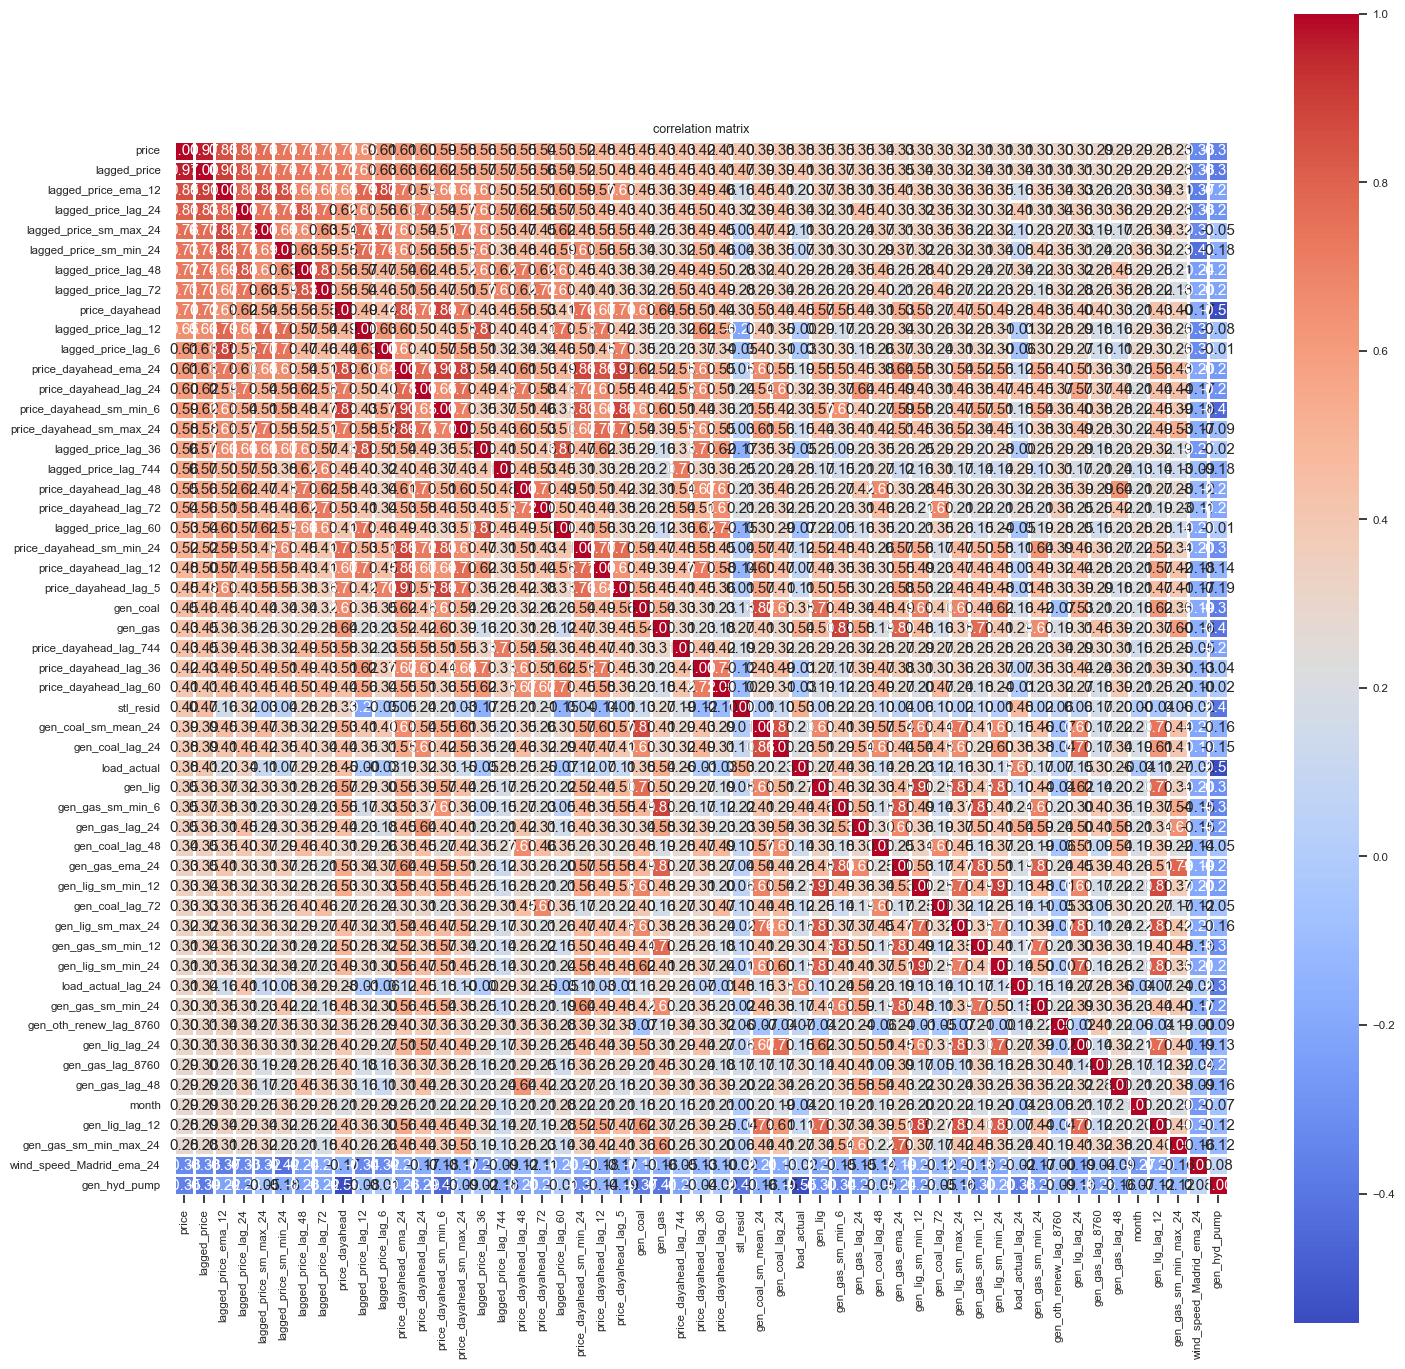

In [113]:
plt.figure(figsize = (17,17))
sns.set(font_scale=0.75)
ax = sns.heatmap(
    df_corr, 
    annot=True, 
    square=True, 
    linewidths=.75, cmap="coolwarm", 
    fmt = ".2f", 
    annot_kws = {"size": 11}
)
ax.xaxis.tick_bottom()
plt.title("correlation matrix")
plt.show()

# Modeling

### Hyperparameter Tunning & Model Selection

In [114]:
train_periods = int(y.shape[0] * 0.8)
test_periods = int(y.shape[0] * 0.2)

X_train, X_test = X_stand.iloc[:train_periods], X_stand.iloc[train_periods:train_periods+test_periods]
y_train, y_test = y.iloc[:train_periods], y.iloc[train_periods:train_periods+test_periods]
X_forecast = X_stand.iloc[train_periods+test_periods:]

In [115]:
X_train.shape, X_test.shape

((28051, 52), (7012, 52))

In [116]:
y_train.shape, y_test.shape

((28051,), (7012,))

In [117]:
# Define the search space
algorithms = [    
    'random_forest',
    'lightgbm',
    'lstm'
]

int_parameters = [
    # random_forest
    'random_forest.n_estimators',
    'random_forest.max_depth',
    'random_forest.min_samples_split',
    
    # lightgbm
    'lightgbm.n_estimators',
    'lightgbm.max_depth',
    'lightgbm.min_child_samples',
    'num_leaves',
    
    # lstm
    'layers',
    'units',
    'batch_size'
]

choice_parameters = {
    # random_forest
    "random_forest.max_features": [1.0, 'sqrt'],
    
    # lightgbm
    "boosting_type": ['gbdt', 'dart'],

    # lstm
    "topology": ['classic', 'bidirectional', 'convolutional'],
    "units": [16, 32, 64, 128, 256],
    "batch_size": [16, 32, 64, 128, 256]
}

model_type_choices = [
    # Random Forest Search Space
    {
        "algorithm": 'random_forest',
        "random_forest.n_estimators": scope.int(hp.quniform('random_forest.n_estimators', 5, 200, 1)),
        "random_forest.max_depth": scope.int(hp.quniform('random_forest.max_depth', 1, 100, 1)),
        "random_forest.min_samples_split": scope.int(hp.quniform('random_forest.min_samples_split', 5, 100, 1)),
        "random_forest.max_features": hp.choice('random_forest.max_features', choice_parameters['random_forest.max_features']),
    },
    
    # LightGBM Search Space
    {
        "algorithm": 'lightgbm',
        "boosting_type": hp.choice('boosting_type', choice_parameters['boosting_type']),
        "lightgbm.n_estimators": scope.int(hp.quniform('lightgbm.n_estimators', 5, 350, 1)),
        "lightgbm.max_depth": scope.int(hp.quniform('lightgbm.max_depth', 1, 175, 1)),
        "lightgbm.min_child_samples": scope.int(hp.quniform('lightgbm.min_child_samples', 5, 100, 1)),
        "lightgbm.learning_rate": hp.loguniform('lightgbm.learning_rate', np.log(0.001), np.log(0.3)),
        "num_leaves": scope.int(hp.quniform('num_leaves', 5, 150, 1)),        
        "colsample_bytree": hp.uniform('colsample_bytree', 0.5, 1)
    },
    
    # LSTM Search Space
    {
        "algorithm": 'lstm',
        # "topology": hp.choice('topology', choice_parameters['topology']),
        "layers": scope.int(hp.quniform('layers', 1, 10, 1)), 
        "units": scope.int(hp.choice('units', choice_parameters['units'])),
        "dropout": hp.uniform('dropout', 0.0, 0.5),
        "recurrent_dropout": hp.uniform('recurrent_dropout', 0.0, 0.5),
        "lstm.learning_rate": hp.loguniform('lstm.learning_rate', np.log(0.001), np.log(0.1)),
        # "batch_size": scope.int(hp.choice('batch_size', choice_parameters['batch_size'])),
    }
]

search_space = {
    "model_type": hp.choice('model_type', model_type_choices)
}

In [121]:
def find_trials():
    def extract_param_idx(name, value):
        if name in choice_parameters:
            return choice_parameters[name].index(value)
        return value
    
    def find_trials_dict(champion: bool = True):        
        # Load Champion
        model = Regressor()
        model.load(champion=champion)

        # Define dict
        trials_dict = {
            'model_type': algorithms.index(model.algorithm)
        }
        trials_dict.update({
            k: extract_param_idx(k, v) for k, v in model.hyper_parameters.items()
        })
        
        return trials_dict
    
    trials_list = [find_trials_dict(champ) for champ in [True, False]]
    
    return generate_trials_to_calculate(trials_list)


def objective(params: dict):
    try:
        # Extract algorithm
        algorithm = params['model_type']['algorithm']

        # Append params to trials
        trials.append(params)

        # Extract Hyper Parameters
        hyper_parameters = {
            k: v for k, v in params['model_type'].items() if k != 'algorithm'
        }

        ts_split = TimeSeriesSplit(n_splits=3, test_size=test_periods)

        scores = []

        for train_idx, val_idx in ts_split.split(X_train):
            # Split Features
            train_features = X_train.iloc[train_idx]
            val_features = X_train.iloc[val_idx]

            # Split Target
            train_target = y_train.iloc[train_idx]
            val_target = y_train.iloc[val_idx]

            # Instanciate the Regressor
            model = Regressor(
                algorithm=algorithm,
                hyper_parameters=hyper_parameters,
            )

            # Build the model
            model.build(
                train_target=train_target.copy(), 
                train_features=train_features.copy()
            )

            # Fit the model
            model.fit(
                train_target=train_target.copy(), 
                train_features=train_features.copy()
            )

            # Predict the Validation Dataset
            val_pred = model.predict(
                train_target=train_target.copy(), 
                forecast_features=val_features.copy(), 
                forecast_dates=val_features.index
            )

            scores.append(mean_absolute_percentage_error(val_target, val_pred))

        return {'loss': np.mean(scores), 'status': STATUS_OK}
    except Exception as e:
        return {'loss': np.inf, 'status': STATUS_OK}

In [122]:
# find_trials()

In [123]:
trials = []

result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    # trials=find_trials(),
    max_evals=300,
    timeout=10 * 60, # 30 mins
    verbose=True,
    show_progressbar=True,
    early_stop_fn=None
)

 27%|██▋       | 81/300 [10:06<27:19,  7.49s/trial, best loss: 0.04744153157787665]  


In [124]:
result

{'model_type': 0,
 'random_forest.max_depth': 76.0,
 'random_forest.max_features': 0,
 'random_forest.min_samples_split': 60.0,
 'random_forest.n_estimators': 182.0}

In [125]:
algos = [t['model_type']['algorithm'] for t in trials]
counts = Counter(algos)

for algo, reps in counts.items():
    print(f"{algo}: {round(reps * 100 / len(algos), 1)} %")

lightgbm: 18.5 %
lstm: 21.0 %
random_forest: 60.5 %


### Model Evaluation

In [126]:
# Instanciate the "challenger" model

In [127]:
def extract_challenger(results: dict):
    def extract_parameter(k, v):
        if k in choice_parameters:
            v = choice_parameters[k][v]
        if k in int_parameters:
            v = int(v)
        return v
    
    algorithm = algorithms[results['model_type']]
    
    hyper_parameters = {
        k: extract_parameter(k, v) for k, v in results.items() if k not in ['algorithm', 'model_type']
    }
    
    return Regressor(
        algorithm=algorithm,
        hyper_parameters=hyper_parameters
    )

In [128]:
challenger = extract_challenger(result)

In [129]:
challenger

In [130]:
# Build & Re-fit model
challenger.build(
    train_target=y_train, 
    train_features=X_train
)

challenger.fit(
    train_target=y_train, 
    train_features=X_train
)

In [131]:
# Save Challenger
challenger.save(as_champion=False)

itba_ml.modeling.models: 2024-05-27 12:19:22,759 | INFO | models.py:200 | Saving new challenger.


In [132]:
# Forecast Test Data
test_pred = challenger.predict(
    train_target=y_train, 
    forecast_features=X_test, 
    forecast_dates=X_test.index
)

In [133]:
# Evaluate Performance (on unseen data)

In [134]:
challenger_mape = mean_absolute_percentage_error(y_test, test_pred)

In [135]:
challenger_mape

0.031100955658625286

### Champion Update

In [136]:
if os.path.exists(os.path.join('..', 'models', 'regressor', 'champion', 'champion.pickle')):
    # Load Champion
    champion = Regressor()
    champion.load(champion=True)
    
    # Fit champion
    champion.fit(
        train_target=y_train, 
        train_features=X_train
    )
    
    # Forecast test data
    test_pred = champion.predict(
        train_target=y_train, 
        forecast_features=X_test, 
        forecast_dates=X_test.index
    )
    
    # Evaluate champion
    champion_mape = mean_absolute_percentage_error(y_test, test_pred)
    
    print(f'champion_mape: {round(champion_mape*100, 2)} %\n'
          f'challenger_mape: {round(challenger_mape*100, 2)} %\n')
    
    if challenger_mape < champion_mape:
        challenger.save(as_champion=True)
else:
    challenger.save(as_champion=True)

itba_ml.modeling.models: 2024-05-27 12:19:22,819 | INFO | models.py:219 | Loading champion.
champion_mape: 3.11 %
challenger_mape: 3.11 %

itba_ml.modeling.models: 2024-05-27 12:19:35,716 | INFO | models.py:192 | Saving new champion.
